In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

176


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:59<00:00,  1.01it/s]


In [12]:
Dataset = 'MAP Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 7.055903196334839 [s] ... size 887.702213 MB


In [14]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 17.154690265655518 [s] ... size 1183.602268 MB


In [15]:
del images_left_bgr,images_right_bgr

In [17]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [16]:
from timeit import default_timer as timer

In [17]:
time_all = []

In [18]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [19]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


In [20]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 330911.56it/s]


In [21]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [22]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [23]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [24]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [25]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [26]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [27]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


In [28]:
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 66779.42it/s]


In [29]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [30]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [31]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [32]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [33]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [34]:
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [35]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:19<00:00,  7.32s/it]


In [36]:
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 169924.54it/s]


In [37]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [38]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [39]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [40]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [41]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [42]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [43]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [44]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


In [45]:
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 18709.95it/s]


In [46]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [47]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [48]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [49]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [50]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [51]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [52]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


In [53]:
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252795.82it/s]


In [54]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [55]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [56]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [57]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [58]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [59]:
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [60]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:08<00:00,  1.15s/it]


In [61]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 41265.60it/s]


In [62]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [63]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [64]:
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [65]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [66]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [67]:
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
'''
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

In [72]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [68]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [69]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:57<00:00,  2.95s/it]


In [70]:
for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 48989.34it/s]


In [71]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [72]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [73]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [74]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [75]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [76]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [77]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [78]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [79]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [80]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [81]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [82]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [83]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:08<08:50,  8.84s/it]


Number of matches 55677
Number of matches After Lowe's Ratio 1696
Number of Robust matches 1365




  3%|▎         | 2/61 [00:17<08:46,  8.93s/it]


Number of matches 57353
Number of matches After Lowe's Ratio 1704
Number of Robust matches 1532




  5%|▍         | 3/61 [00:28<08:56,  9.26s/it]


Number of matches 60333
Number of matches After Lowe's Ratio 1642
Number of Robust matches 1216




  7%|▋         | 4/61 [00:37<08:47,  9.26s/it]


Number of matches 60160
Number of matches After Lowe's Ratio 1411
Number of Robust matches 1151




  8%|▊         | 5/61 [00:47<08:48,  9.44s/it]


Number of matches 59732
Number of matches After Lowe's Ratio 109
Number of Robust matches 91




 10%|▉         | 6/61 [00:55<08:20,  9.10s/it]


Number of matches 50748
Number of matches After Lowe's Ratio 2984
Number of Robust matches 2715




 11%|█▏        | 7/61 [01:03<07:56,  8.83s/it]


Number of matches 49229
Number of matches After Lowe's Ratio 2034
Number of Robust matches 1938




 13%|█▎        | 8/61 [01:10<07:20,  8.32s/it]


Number of matches 44902
Number of matches After Lowe's Ratio 1852
Number of Robust matches 1713




 15%|█▍        | 9/61 [01:17<06:49,  7.88s/it]


Number of matches 42126
Number of matches After Lowe's Ratio 1982
Number of Robust matches 1692




 16%|█▋        | 10/61 [01:23<06:12,  7.31s/it]


Number of matches 41155
Number of matches After Lowe's Ratio 1828
Number of Robust matches 1798




 18%|█▊        | 11/61 [01:29<05:46,  6.93s/it]


Number of matches 38377
Number of matches After Lowe's Ratio 1867
Number of Robust matches 1679




 20%|█▉        | 12/61 [01:34<05:11,  6.35s/it]


Number of matches 39499
Number of matches After Lowe's Ratio 1956
Number of Robust matches 1899




 21%|██▏       | 13/61 [01:40<04:55,  6.16s/it]


Number of matches 37350
Number of matches After Lowe's Ratio 1821
Number of Robust matches 1602




 23%|██▎       | 14/61 [01:45<04:29,  5.73s/it]


Number of matches 35747
Number of matches After Lowe's Ratio 1793
Number of Robust matches 1611




 25%|██▍       | 15/61 [01:49<04:02,  5.28s/it]


Number of matches 34127
Number of matches After Lowe's Ratio 1685
Number of Robust matches 1648




 26%|██▌       | 16/61 [01:53<03:45,  5.02s/it]


Number of matches 31692
Number of matches After Lowe's Ratio 1468
Number of Robust matches 1376




 28%|██▊       | 17/61 [01:57<03:20,  4.57s/it]


Number of matches 28986
Number of matches After Lowe's Ratio 1219
Number of Robust matches 1203




 30%|██▉       | 18/61 [02:00<02:58,  4.15s/it]


Number of matches 28823
Number of matches After Lowe's Ratio 1165
Number of Robust matches 1139




 31%|███       | 19/61 [02:03<02:45,  3.94s/it]


Number of matches 26721
Number of matches After Lowe's Ratio 1158
Number of Robust matches 1081




 33%|███▎      | 20/61 [02:06<02:27,  3.60s/it]


Number of matches 27608
Number of matches After Lowe's Ratio 1107
Number of Robust matches 1084




 34%|███▍      | 21/61 [02:09<02:17,  3.44s/it]


Number of matches 27518
Number of matches After Lowe's Ratio 1193
Number of Robust matches 1140




 36%|███▌      | 22/61 [02:12<02:08,  3.29s/it]


Number of matches 28433
Number of matches After Lowe's Ratio 1206
Number of Robust matches 1148




 38%|███▊      | 23/61 [02:16<02:06,  3.32s/it]


Number of matches 26102
Number of matches After Lowe's Ratio 991
Number of Robust matches 967




 39%|███▉      | 24/61 [02:18<01:57,  3.17s/it]


Number of matches 28894
Number of matches After Lowe's Ratio 858
Number of Robust matches 815




 41%|████      | 25/61 [02:22<01:54,  3.18s/it]


Number of matches 30125
Number of matches After Lowe's Ratio 48
Number of Robust matches 42




 43%|████▎     | 26/61 [02:25<01:57,  3.36s/it]


Number of matches 30185
Number of matches After Lowe's Ratio 2659
Number of Robust matches 2641




 44%|████▍     | 27/61 [02:28<01:51,  3.29s/it]


Number of matches 25802
Number of matches After Lowe's Ratio 1177
Number of Robust matches 1066




 46%|████▌     | 28/61 [02:31<01:41,  3.09s/it]


Number of matches 25870
Number of matches After Lowe's Ratio 1065
Number of Robust matches 1022




 48%|████▊     | 29/61 [02:34<01:39,  3.11s/it]


Number of matches 27741
Number of matches After Lowe's Ratio 1106
Number of Robust matches 1059




 49%|████▉     | 30/61 [02:37<01:34,  3.06s/it]


Number of matches 25980
Number of matches After Lowe's Ratio 1182
Number of Robust matches 1122




 51%|█████     | 31/61 [02:40<01:28,  2.96s/it]


Number of matches 26420
Number of matches After Lowe's Ratio 1244
Number of Robust matches 1190




 52%|█████▏    | 32/61 [02:43<01:25,  2.94s/it]


Number of matches 30232
Number of matches After Lowe's Ratio 1239
Number of Robust matches 1084




 54%|█████▍    | 33/61 [02:47<01:30,  3.22s/it]


Number of matches 30957
Number of matches After Lowe's Ratio 1434
Number of Robust matches 1392




 56%|█████▌    | 34/61 [02:50<01:30,  3.34s/it]


Number of matches 33625
Number of matches After Lowe's Ratio 1643
Number of Robust matches 1626




 57%|█████▋    | 35/61 [02:55<01:36,  3.72s/it]


Number of matches 36438
Number of matches After Lowe's Ratio 1867
Number of Robust matches 1810




 59%|█████▉    | 36/61 [03:00<01:39,  3.98s/it]


Number of matches 37330
Number of matches After Lowe's Ratio 1788
Number of Robust matches 1634




 61%|██████    | 37/61 [03:04<01:41,  4.23s/it]


Number of matches 38578
Number of matches After Lowe's Ratio 2008
Number of Robust matches 1979




 62%|██████▏   | 38/61 [03:10<01:48,  4.73s/it]


Number of matches 41159
Number of matches After Lowe's Ratio 1932
Number of Robust matches 1852




 64%|██████▍   | 39/61 [03:16<01:50,  5.03s/it]


Number of matches 39072
Number of matches After Lowe's Ratio 1612
Number of Robust matches 1471




 66%|██████▌   | 40/61 [03:22<01:51,  5.33s/it]


Number of matches 46117
Number of matches After Lowe's Ratio 1398
Number of Robust matches 1383




 67%|██████▋   | 41/61 [03:29<01:57,  5.86s/it]


Number of matches 49031
Number of matches After Lowe's Ratio 59
Number of Robust matches 51




 69%|██████▉   | 42/61 [03:37<02:01,  6.37s/it]


Number of matches 44393
Number of matches After Lowe's Ratio 3335
Number of Robust matches 3041




 70%|███████   | 43/61 [03:43<01:54,  6.33s/it]


Number of matches 42074
Number of matches After Lowe's Ratio 1928
Number of Robust matches 1891




 72%|███████▏  | 44/61 [03:49<01:47,  6.35s/it]


Number of matches 39716
Number of matches After Lowe's Ratio 1920
Number of Robust matches 1731




 74%|███████▍  | 45/61 [03:54<01:36,  6.01s/it]


Number of matches 37382
Number of matches After Lowe's Ratio 1749
Number of Robust matches 1736




 75%|███████▌  | 46/61 [03:59<01:23,  5.58s/it]


Number of matches 36166
Number of matches After Lowe's Ratio 1502
Number of Robust matches 1414




 77%|███████▋  | 47/61 [04:04<01:15,  5.37s/it]


Number of matches 35401
Number of matches After Lowe's Ratio 1496
Number of Robust matches 1350




 79%|███████▊  | 48/61 [04:08<01:05,  5.06s/it]


Number of matches 35752
Number of matches After Lowe's Ratio 1379
Number of Robust matches 1367




 80%|████████  | 49/61 [04:13<00:59,  4.95s/it]


Number of matches 33540
Number of matches After Lowe's Ratio 1126
Number of Robust matches 1079




 82%|████████▏ | 50/61 [04:17<00:50,  4.59s/it]


Number of matches 32424
Number of matches After Lowe's Ratio 1087
Number of Robust matches 867




 84%|████████▎ | 51/61 [04:21<00:44,  4.40s/it]


Number of matches 37874
Number of matches After Lowe's Ratio 850
Number of Robust matches 759




 85%|████████▌ | 52/61 [04:26<00:41,  4.59s/it]


Number of matches 34672
Number of matches After Lowe's Ratio 98
Number of Robust matches 67




 87%|████████▋ | 53/61 [04:30<00:35,  4.41s/it]


Number of matches 34302
Number of matches After Lowe's Ratio 2588
Number of Robust matches 2563




 89%|████████▊ | 54/61 [04:33<00:29,  4.20s/it]


Number of matches 28224
Number of matches After Lowe's Ratio 1179
Number of Robust matches 1162




 90%|█████████ | 55/61 [04:37<00:24,  4.02s/it]


Number of matches 31953
Number of matches After Lowe's Ratio 1170
Number of Robust matches 1164




 92%|█████████▏| 56/61 [04:41<00:19,  3.92s/it]


Number of matches 33085
Number of matches After Lowe's Ratio 1338
Number of Robust matches 1327




 93%|█████████▎| 57/61 [04:45<00:16,  4.05s/it]


Number of matches 35882
Number of matches After Lowe's Ratio 1534
Number of Robust matches 1359




 95%|█████████▌| 58/61 [04:50<00:12,  4.20s/it]


Number of matches 41389
Number of matches After Lowe's Ratio 1415
Number of Robust matches 1397




 97%|█████████▋| 59/61 [04:55<00:09,  4.56s/it]


Number of matches 36865
Number of matches After Lowe's Ratio 202
Number of Robust matches 188




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 34808
Number of matches After Lowe's Ratio 2213
Number of Robust matches 2177




  2%|▏         | 1/60 [00:08<08:27,  8.60s/it]


Number of matches 54452
Number of matches After Lowe's Ratio 1979
Number of Robust matches 1915




  3%|▎         | 2/60 [00:17<08:18,  8.59s/it]


Number of matches 48940
Number of matches After Lowe's Ratio 2016
Number of Robust matches 1921




  5%|▌         | 3/60 [00:24<07:50,  8.26s/it]


Number of matches 47194
Number of matches After Lowe's Ratio 1837
Number of Robust matches 1687




  7%|▋         | 4/60 [00:31<07:21,  7.89s/it]


Number of matches 41380
Number of matches After Lowe's Ratio 1997
Number of Robust matches 1945




  8%|▊         | 5/60 [00:37<06:39,  7.26s/it]


Number of matches 44346
Number of matches After Lowe's Ratio 1848
Number of Robust matches 1806




 10%|█         | 6/60 [00:44<06:22,  7.08s/it]


Number of matches 40464
Number of matches After Lowe's Ratio 1635
Number of Robust matches 1551




 12%|█▏        | 7/60 [00:49<05:47,  6.55s/it]


Number of matches 37867
Number of matches After Lowe's Ratio 1599
Number of Robust matches 1386




 13%|█▎        | 8/60 [00:54<05:18,  6.12s/it]


Number of matches 35389
Number of matches After Lowe's Ratio 1447
Number of Robust matches 1434




 15%|█▌        | 9/60 [00:58<04:41,  5.51s/it]


Number of matches 32892
Number of matches After Lowe's Ratio 1298
Number of Robust matches 1256




 17%|█▋        | 10/60 [01:02<04:07,  4.96s/it]


Number of matches 32656
Number of matches After Lowe's Ratio 1220
Number of Robust matches 1200




 18%|█▊        | 11/60 [01:06<03:49,  4.69s/it]


Number of matches 29010
Number of matches After Lowe's Ratio 1132
Number of Robust matches 1005




 20%|██        | 12/60 [01:09<03:25,  4.29s/it]


Number of matches 27352
Number of matches After Lowe's Ratio 1041
Number of Robust matches 922




 22%|██▏       | 13/60 [01:12<03:00,  3.84s/it]


Number of matches 25731
Number of matches After Lowe's Ratio 970
Number of Robust matches 962




 23%|██▎       | 14/60 [01:15<02:39,  3.46s/it]


Number of matches 25879
Number of matches After Lowe's Ratio 1115
Number of Robust matches 1102




 25%|██▌       | 15/60 [01:18<02:30,  3.35s/it]


Number of matches 24859
Number of matches After Lowe's Ratio 1078
Number of Robust matches 967




 27%|██▋       | 16/60 [01:20<02:16,  3.10s/it]


Number of matches 24971
Number of matches After Lowe's Ratio 1088
Number of Robust matches 983




 28%|██▊       | 17/60 [01:23<02:05,  2.92s/it]


Number of matches 25611
Number of matches After Lowe's Ratio 1092
Number of Robust matches 1041




 30%|███       | 18/60 [01:25<01:57,  2.79s/it]


Number of matches 22090
Number of matches After Lowe's Ratio 1094
Number of Robust matches 1002




 32%|███▏      | 19/60 [01:28<01:52,  2.75s/it]


Number of matches 23131
Number of matches After Lowe's Ratio 1242
Number of Robust matches 1208




 33%|███▎      | 20/60 [01:30<01:44,  2.62s/it]


Number of matches 24081
Number of matches After Lowe's Ratio 2365
Number of Robust matches 2348




 35%|███▌      | 21/60 [01:33<01:40,  2.57s/it]


Number of matches 27200
Number of matches After Lowe's Ratio 110
Number of Robust matches 102




 37%|███▋      | 22/60 [01:35<01:39,  2.62s/it]


Number of matches 23490
Number of matches After Lowe's Ratio 1416
Number of Robust matches 1399




 38%|███▊      | 23/60 [01:38<01:38,  2.67s/it]


Number of matches 23414
Number of matches After Lowe's Ratio 1462
Number of Robust matches 1415




 40%|████      | 24/60 [01:40<01:31,  2.55s/it]


Number of matches 23735
Number of matches After Lowe's Ratio 1480
Number of Robust matches 1444




 42%|████▏     | 25/60 [01:43<01:27,  2.50s/it]


Number of matches 23963
Number of matches After Lowe's Ratio 1286
Number of Robust matches 1275




 43%|████▎     | 26/60 [01:46<01:28,  2.60s/it]


Number of matches 24774
Number of matches After Lowe's Ratio 1286
Number of Robust matches 1128




 45%|████▌     | 27/60 [01:48<01:25,  2.58s/it]


Number of matches 25854
Number of matches After Lowe's Ratio 1066
Number of Robust matches 1041




 47%|████▋     | 28/60 [01:51<01:25,  2.66s/it]


Number of matches 28455
Number of matches After Lowe's Ratio 1171
Number of Robust matches 1082




 48%|████▊     | 29/60 [01:54<01:27,  2.83s/it]


Number of matches 31213
Number of matches After Lowe's Ratio 1307
Number of Robust matches 1083




 50%|█████     | 30/60 [01:58<01:36,  3.20s/it]


Number of matches 32573
Number of matches After Lowe's Ratio 1330
Number of Robust matches 1318




 52%|█████▏    | 31/60 [02:02<01:39,  3.42s/it]


Number of matches 35428
Number of matches After Lowe's Ratio 1355
Number of Robust matches 1335




 53%|█████▎    | 32/60 [02:07<01:48,  3.88s/it]


Number of matches 36398
Number of matches After Lowe's Ratio 1718
Number of Robust matches 1500




 55%|█████▌    | 33/60 [02:12<01:50,  4.10s/it]


Number of matches 35516
Number of matches After Lowe's Ratio 1508
Number of Robust matches 1485




 57%|█████▋    | 34/60 [02:16<01:49,  4.22s/it]


Number of matches 38135
Number of matches After Lowe's Ratio 1459
Number of Robust matches 1417




 58%|█████▊    | 35/60 [02:22<01:56,  4.68s/it]


Number of matches 40907
Number of matches After Lowe's Ratio 1593
Number of Robust matches 1568




 60%|██████    | 36/60 [02:28<02:00,  5.02s/it]


Number of matches 45834
Number of matches After Lowe's Ratio 1910
Number of Robust matches 1860




 62%|██████▏   | 37/60 [02:35<02:11,  5.73s/it]


Number of matches 51125
Number of matches After Lowe's Ratio 1963
Number of Robust matches 1929




 63%|██████▎   | 38/60 [02:44<02:22,  6.50s/it]


Number of matches 53354
Number of matches After Lowe's Ratio 2149
Number of Robust matches 2107




 65%|██████▌   | 39/60 [02:53<02:35,  7.40s/it]


Number of matches 62095
Number of matches After Lowe's Ratio 2113
Number of Robust matches 1877




 67%|██████▋   | 40/60 [03:03<02:43,  8.19s/it]


Number of matches 64652
Number of matches After Lowe's Ratio 1958
Number of Robust matches 1740




 68%|██████▊   | 41/60 [03:13<02:47,  8.83s/it]


Number of matches 63650
Number of matches After Lowe's Ratio 1914
Number of Robust matches 1754




 70%|███████   | 42/60 [03:23<02:42,  9.04s/it]


Number of matches 61780
Number of matches After Lowe's Ratio 1899
Number of Robust matches 1778




 72%|███████▏  | 43/60 [03:32<02:36,  9.20s/it]


Number of matches 59478
Number of matches After Lowe's Ratio 1730
Number of Robust matches 1531




 73%|███████▎  | 44/60 [03:43<02:32,  9.53s/it]


Number of matches 61405
Number of matches After Lowe's Ratio 1511
Number of Robust matches 1247




 75%|███████▌  | 45/60 [03:52<02:20,  9.36s/it]


Number of matches 58456
Number of matches After Lowe's Ratio 1493
Number of Robust matches 1091




 77%|███████▋  | 46/60 [04:01<02:11,  9.37s/it]


Number of matches 58340
Number of matches After Lowe's Ratio 1290
Number of Robust matches 1056




 78%|███████▊  | 47/60 [04:10<02:00,  9.28s/it]


Number of matches 56401
Number of matches After Lowe's Ratio 1036
Number of Robust matches 728




 80%|████████  | 48/60 [04:19<01:50,  9.21s/it]


Number of matches 52691
Number of matches After Lowe's Ratio 911
Number of Robust matches 515




 82%|████████▏ | 49/60 [04:28<01:38,  8.96s/it]


Number of matches 51562
Number of matches After Lowe's Ratio 1537
Number of Robust matches 696




 83%|████████▎ | 50/60 [04:34<01:21,  8.19s/it]


Number of matches 32746
Number of matches After Lowe's Ratio 124
Number of Robust matches 113




 85%|████████▌ | 51/60 [04:38<01:01,  6.81s/it]


Number of matches 30240
Number of matches After Lowe's Ratio 549
Number of Robust matches 511




 87%|████████▋ | 52/60 [04:42<00:47,  5.97s/it]


Number of matches 39101
Number of matches After Lowe's Ratio 735
Number of Robust matches 676




 88%|████████▊ | 53/60 [04:47<00:41,  5.86s/it]


Number of matches 46417
Number of matches After Lowe's Ratio 738
Number of Robust matches 648




 90%|█████████ | 54/60 [04:54<00:37,  6.25s/it]


Number of matches 42921
Number of matches After Lowe's Ratio 804
Number of Robust matches 516




 92%|█████████▏| 55/60 [05:00<00:30,  6.16s/it]


Number of matches 45401
Number of matches After Lowe's Ratio 778
Number of Robust matches 590




 93%|█████████▎| 56/60 [05:07<00:25,  6.44s/it]


Number of matches 47348
Number of matches After Lowe's Ratio 974
Number of Robust matches 718




 95%|█████████▌| 57/60 [05:15<00:20,  6.79s/it]


Number of matches 53207
Number of matches After Lowe's Ratio 1045
Number of Robust matches 650




 97%|█████████▋| 58/60 [05:24<00:14,  7.32s/it]


Number of matches 52534
Number of matches After Lowe's Ratio 1012
Number of Robust matches 610




 98%|█████████▊| 59/60 [05:32<00:07,  7.53s/it]


Number of matches 55556
Number of matches After Lowe's Ratio 1201
Number of Robust matches 758




In [84]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.020707368850708008 [s] ... size 0.006368 MB


In [85]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00494694709777832 [s] ... size 0.006296 MB


In [86]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [87]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [88]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [89]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/61 [00:01<01:17,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 429
Number of Robust matches 310




  3%|▎         | 2/61 [00:02<01:16,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 336
Number of Robust matches 203




  5%|▍         | 3/61 [00:03<01:15,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 239
Number of Robust matches 127




  7%|▋         | 4/61 [00:05<01:13,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 154
Number of Robust matches 57




  8%|▊         | 5/61 [00:06<01:20,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 80
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1584
Number of Robust matches New 6




 10%|▉         | 6/61 [00:08<01:16,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 865
Number of Robust matches 653




 11%|█▏        | 7/61 [00:09<01:13,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 628
Number of Robust matches 475




 13%|█▎        | 8/61 [00:10<01:11,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 831
Number of Robust matches 760




 15%|█▍        | 9/61 [00:12<01:13,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 911
Number of Robust matches 763




 16%|█▋        | 10/61 [00:13<01:10,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 953
Number of Robust matches 781




 18%|█▊        | 11/61 [00:15<01:07,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1193
Number of Robust matches 1124




 20%|█▉        | 12/61 [00:16<01:05,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1104
Number of Robust matches 960




 21%|██▏       | 13/61 [00:17<01:04,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 913
Number of Robust matches 858




 23%|██▎       | 14/61 [00:19<01:06,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1095
Number of Robust matches 954




 25%|██▍       | 15/61 [00:20<01:03,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1071
Number of Robust matches 996




 26%|██▌       | 16/61 [00:21<01:00,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 877
Number of Robust matches 769




 28%|██▊       | 17/61 [00:23<00:58,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 750
Number of Robust matches 651




 30%|██▉       | 18/61 [00:24<00:57,  1.33s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 780
Number of Robust matches 651




 31%|███       | 19/61 [00:26<00:59,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 816
Number of Robust matches 655




 33%|███▎      | 20/61 [00:27<00:56,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 782
Number of Robust matches 718




 34%|███▍      | 21/61 [00:28<00:54,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 850
Number of Robust matches 672




 36%|███▌      | 22/61 [00:29<00:52,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 749
Number of Robust matches 638




 38%|███▊      | 23/61 [00:31<00:50,  1.33s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 673
Number of Robust matches 455




 39%|███▉      | 24/61 [00:32<00:52,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 559
Number of Robust matches 389




 41%|████      | 25/61 [00:34<00:51,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 101
Number of Robust matches 20


Number of matches After Lowe's Ratio New 1762
Number of Robust matches New 8




 43%|████▎     | 26/61 [00:35<00:49,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1941
Number of Robust matches 1878




 44%|████▍     | 27/61 [00:36<00:46,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1008
Number of Robust matches 852




 46%|████▌     | 28/61 [00:38<00:47,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 905
Number of Robust matches 710




 48%|████▊     | 29/61 [00:39<00:45,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 831
Number of Robust matches 718




 49%|████▉     | 30/61 [00:41<00:43,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 912
Number of Robust matches 814




 51%|█████     | 31/61 [00:42<00:41,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 871
Number of Robust matches 803




 52%|█████▏    | 32/61 [00:43<00:39,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 820
Number of Robust matches 732




 54%|█████▍    | 33/61 [00:45<00:40,  1.44s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 925
Number of Robust matches 851




 56%|█████▌    | 34/61 [00:46<00:37,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 947
Number of Robust matches 781




 57%|█████▋    | 35/61 [00:48<00:35,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 996
Number of Robust matches 859




 59%|█████▉    | 36/61 [00:49<00:34,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1032
Number of Robust matches 925




 61%|██████    | 37/61 [00:50<00:32,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1086
Number of Robust matches 984




 62%|██████▏   | 38/61 [00:52<00:32,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 967
Number of Robust matches 849




 64%|██████▍   | 39/61 [00:53<00:30,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 954
Number of Robust matches 839




 66%|██████▌   | 40/61 [00:55<00:28,  1.37s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 786
Number of Robust matches 620




 67%|██████▋   | 41/61 [00:56<00:27,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 65
Number of Robust matches 21


Number of matches After Lowe's Ratio New 1524
Number of Robust matches New 7




 69%|██████▉   | 42/61 [00:58<00:27,  1.45s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1458
Number of Robust matches 1335




 70%|███████   | 43/61 [00:59<00:25,  1.42s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 962
Number of Robust matches 908




 72%|███████▏  | 44/61 [01:00<00:23,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1053
Number of Robust matches 969




 74%|███████▍  | 45/61 [01:02<00:21,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 985
Number of Robust matches 895




 75%|███████▌  | 46/61 [01:03<00:20,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 911
Number of Robust matches 831




 77%|███████▋  | 47/61 [01:04<00:19,  1.41s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 931
Number of Robust matches 747




 79%|███████▊  | 48/61 [01:06<00:17,  1.38s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 910
Number of Robust matches 816




 80%|████████  | 49/61 [01:07<00:16,  1.36s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 746
Number of Robust matches 571




 82%|████████▏ | 50/61 [01:08<00:14,  1.34s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 759
Number of Robust matches 671




 84%|████████▎ | 51/61 [01:10<00:13,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 681
Number of Robust matches 596




 85%|████████▌ | 52/61 [01:11<00:12,  1.43s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 164
Number of Robust matches 60




 87%|████████▋ | 53/61 [01:13<00:11,  1.39s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2200
Number of Robust matches 1824




 89%|████████▊ | 54/61 [01:14<00:09,  1.33s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1022
Number of Robust matches 941




 90%|█████████ | 55/61 [01:15<00:07,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 948
Number of Robust matches 803




 92%|█████████▏| 56/61 [01:17<00:06,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1008
Number of Robust matches 913




 93%|█████████▎| 57/61 [01:18<00:05,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 935
Number of Robust matches 804




 95%|█████████▌| 58/61 [01:19<00:03,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 745
Number of Robust matches 639




 97%|█████████▋| 59/61 [01:20<00:02,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 183
Number of Robust matches 105




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 1262
Number of Robust matches 1103




  2%|▏         | 1/60 [00:01<01:27,  1.48s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 503
Number of Robust matches 407




  3%|▎         | 2/60 [00:02<01:21,  1.40s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 628
Number of Robust matches 467




  5%|▌         | 3/60 [00:03<01:15,  1.33s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 699
Number of Robust matches 532




  7%|▋         | 4/60 [00:05<01:11,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 769
Number of Robust matches 683




  8%|▊         | 5/60 [00:06<01:09,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 813
Number of Robust matches 685




 10%|█         | 6/60 [00:07<01:11,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 670
Number of Robust matches 514




 12%|█▏        | 7/60 [00:08<01:08,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 811
Number of Robust matches 711




 13%|█▎        | 8/60 [00:10<01:06,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 818
Number of Robust matches 730




 15%|█▌        | 9/60 [00:11<01:03,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 832
Number of Robust matches 688




 17%|█▋        | 10/60 [00:12<01:05,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 819
Number of Robust matches 735




 18%|█▊        | 11/60 [00:14<01:02,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 797
Number of Robust matches 699




 20%|██        | 12/60 [00:15<01:00,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 733
Number of Robust matches 636




 22%|██▏       | 13/60 [00:16<00:58,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 743
Number of Robust matches 620




 23%|██▎       | 14/60 [00:17<00:56,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 799
Number of Robust matches 740




 25%|██▌       | 15/60 [00:19<00:58,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 821
Number of Robust matches 639




 27%|██▋       | 16/60 [00:20<00:55,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 730
Number of Robust matches 621




 28%|██▊       | 17/60 [00:21<00:53,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 732
Number of Robust matches 630




 30%|███       | 18/60 [00:22<00:51,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 787
Number of Robust matches 657




 32%|███▏      | 19/60 [00:23<00:49,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 991
Number of Robust matches 836




 33%|███▎      | 20/60 [00:25<00:52,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1902
Number of Robust matches 1708




 35%|███▌      | 21/60 [00:26<00:49,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 148
Number of Robust matches 67




 37%|███▋      | 22/60 [00:27<00:47,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 957
Number of Robust matches 892




 38%|███▊      | 23/60 [00:28<00:45,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1204
Number of Robust matches 1079




 40%|████      | 24/60 [00:30<00:46,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1205
Number of Robust matches 1035




 42%|████▏     | 25/60 [00:31<00:44,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 985
Number of Robust matches 915




 43%|████▎     | 26/60 [00:32<00:41,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 970
Number of Robust matches 697




 45%|████▌     | 27/60 [00:33<00:40,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 762
Number of Robust matches 670




 47%|████▋     | 28/60 [00:35<00:38,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 774
Number of Robust matches 573




 48%|████▊     | 29/60 [00:36<00:39,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 808
Number of Robust matches 737




 50%|█████     | 30/60 [00:37<00:37,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 844
Number of Robust matches 762




 52%|█████▏    | 31/60 [00:38<00:35,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 791
Number of Robust matches 683




 53%|█████▎    | 32/60 [00:40<00:34,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 919
Number of Robust matches 803




 55%|█████▌    | 33/60 [00:41<00:32,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 850
Number of Robust matches 673




 57%|█████▋    | 34/60 [00:42<00:33,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 831
Number of Robust matches 723




 58%|█████▊    | 35/60 [00:43<00:31,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 739
Number of Robust matches 664




 60%|██████    | 36/60 [00:45<00:29,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 762
Number of Robust matches 693




 62%|██████▏   | 37/60 [00:46<00:27,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 700
Number of Robust matches 633




 63%|██████▎   | 38/60 [00:47<00:26,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 644
Number of Robust matches 525




 65%|██████▌   | 39/60 [00:48<00:26,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 581
Number of Robust matches 453




 67%|██████▋   | 40/60 [00:49<00:24,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 471
Number of Robust matches 366




 68%|██████▊   | 41/60 [00:51<00:23,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 362
Number of Robust matches 243




 70%|███████   | 42/60 [00:52<00:21,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 419
Number of Robust matches 300




 72%|███████▏  | 43/60 [00:53<00:22,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 401
Number of Robust matches 266




 73%|███████▎  | 44/60 [00:55<00:20,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 348
Number of Robust matches 181




 75%|███████▌  | 45/60 [00:56<00:18,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 324
Number of Robust matches 147




 77%|███████▋  | 46/60 [00:57<00:16,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 239
Number of Robust matches 81




 78%|███████▊  | 47/60 [00:58<00:15,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 226
Number of Robust matches 64




 80%|████████  | 48/60 [01:00<00:15,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 237
Number of Robust matches 81




 82%|████████▏ | 49/60 [01:01<00:13,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 582
Number of Robust matches 292




 83%|████████▎ | 50/60 [01:02<00:12,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 60
Number of Robust matches 7


Number of matches After Lowe's Ratio New 1647
Number of Robust matches New 8




 85%|████████▌ | 51/60 [01:03<00:11,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 263
Number of Robust matches 179




 87%|████████▋ | 52/60 [01:04<00:09,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 245
Number of Robust matches 137




 88%|████████▊ | 53/60 [01:06<00:09,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 220
Number of Robust matches 118




 90%|█████████ | 54/60 [01:07<00:07,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 271
Number of Robust matches 119




 92%|█████████▏| 55/60 [01:08<00:06,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 280
Number of Robust matches 113




 93%|█████████▎| 56/60 [01:09<00:04,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 316
Number of Robust matches 139




 95%|█████████▌| 57/60 [01:11<00:03,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 320
Number of Robust matches 146




 97%|█████████▋| 58/60 [01:12<00:02,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 297
Number of Robust matches 134




 98%|█████████▊| 59/60 [01:13<00:01,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 337
Number of Robust matches 181




In [90]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007542133331298828 [s] ... size 0.006368 MB


In [91]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011137247085571289 [s] ... size 0.006296 MB


In [92]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [93]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [94]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [95]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/61 [00:03<03:04,  3.07s/it]


Number of matches 25738
Number of matches After Lowe's Ratio 8826
Number of Robust matches 7932




  3%|▎         | 2/61 [00:06<02:59,  3.05s/it]


Number of matches 27164
Number of matches After Lowe's Ratio 8907
Number of Robust matches 7809



Number of matches 28373
Number of matches After Lowe's Ratio 8596


  5%|▍         | 3/61 [00:10<03:14,  3.36s/it]

Number of Robust matches 6860




  7%|▋         | 4/61 [00:13<03:11,  3.35s/it]


Number of matches 27529
Number of matches After Lowe's Ratio 8485
Number of Robust matches 6795




  8%|▊         | 5/61 [00:16<03:01,  3.25s/it]


Number of matches 24468
Number of matches After Lowe's Ratio 1500
Number of Robust matches 1185



Number of matches 23552
Number of matches After Lowe's Ratio 12190


 10%|▉         | 6/61 [00:19<02:55,  3.19s/it]

Number of Robust matches 10429




 11%|█▏        | 7/61 [00:22<02:41,  3.00s/it]


Number of matches 21632
Number of matches After Lowe's Ratio 8682
Number of Robust matches 6895




 13%|█▎        | 8/61 [00:24<02:28,  2.80s/it]


Number of matches 21055
Number of matches After Lowe's Ratio 8609
Number of Robust matches 7455




 15%|█▍        | 9/61 [00:26<02:21,  2.73s/it]


Number of matches 20022
Number of matches After Lowe's Ratio 8917
Number of Robust matches 8459




 16%|█▋        | 10/61 [00:29<02:10,  2.56s/it]


Number of matches 18806
Number of matches After Lowe's Ratio 8192
Number of Robust matches 6853




 18%|█▊        | 11/61 [00:31<02:00,  2.41s/it]


Number of matches 18514
Number of matches After Lowe's Ratio 8075
Number of Robust matches 7916




 20%|█▉        | 12/61 [00:33<01:56,  2.38s/it]


Number of matches 18327
Number of matches After Lowe's Ratio 7956
Number of Robust matches 7756




 21%|██▏       | 13/61 [00:35<01:48,  2.26s/it]


Number of matches 18360
Number of matches After Lowe's Ratio 7426
Number of Robust matches 5582




 23%|██▎       | 14/61 [00:37<01:42,  2.18s/it]


Number of matches 17735
Number of matches After Lowe's Ratio 7757
Number of Robust matches 6849



Number of matches 17379
Number of matches After Lowe's Ratio 7470


 25%|██▍       | 15/61 [00:39<01:40,  2.18s/it]

Number of Robust matches 6941




 26%|██▌       | 16/61 [00:41<01:32,  2.05s/it]


Number of matches 15782
Number of matches After Lowe's Ratio 6821
Number of Robust matches 6109




 28%|██▊       | 17/61 [00:42<01:21,  1.86s/it]


Number of matches 15115
Number of matches After Lowe's Ratio 5996
Number of Robust matches 5836




 30%|██▉       | 18/61 [00:44<01:13,  1.71s/it]


Number of matches 14464
Number of matches After Lowe's Ratio 5777
Number of Robust matches 5438



Number of matches 14208
Number of matches After Lowe's Ratio 5656


 31%|███       | 19/61 [00:45<01:10,  1.67s/it]

Number of Robust matches 5502




 33%|███▎      | 20/61 [00:47<01:03,  1.56s/it]


Number of matches 14814
Number of matches After Lowe's Ratio 5868
Number of Robust matches 5384




 34%|███▍      | 21/61 [00:48<00:59,  1.49s/it]


Number of matches 15056
Number of matches After Lowe's Ratio 6210
Number of Robust matches 5920




 36%|███▌      | 22/61 [00:49<00:56,  1.45s/it]


Number of matches 15156
Number of matches After Lowe's Ratio 6181
Number of Robust matches 6008




 38%|███▊      | 23/61 [00:51<00:54,  1.42s/it]


Number of matches 14134
Number of matches After Lowe's Ratio 5604
Number of Robust matches 4990




 39%|███▉      | 24/61 [00:52<00:53,  1.44s/it]


Number of matches 13537
Number of matches After Lowe's Ratio 5031
Number of Robust matches 4736




 41%|████      | 25/61 [00:53<00:48,  1.34s/it]


Number of matches 12984
Number of matches After Lowe's Ratio 697
Number of Robust matches 538




 43%|████▎     | 26/61 [00:54<00:45,  1.29s/it]


Number of matches 13031
Number of matches After Lowe's Ratio 8427
Number of Robust matches 8355




 44%|████▍     | 27/61 [00:56<00:42,  1.25s/it]


Number of matches 13225
Number of matches After Lowe's Ratio 5809
Number of Robust matches 5591



Number of matches 13132
Number of matches After Lowe's Ratio 5535


 46%|████▌     | 28/61 [00:57<00:43,  1.32s/it]

Number of Robust matches 4325




 48%|████▊     | 29/61 [00:58<00:40,  1.27s/it]


Number of matches 13345
Number of matches After Lowe's Ratio 5455
Number of Robust matches 5350




 49%|████▉     | 30/61 [00:59<00:38,  1.25s/it]


Number of matches 14259
Number of matches After Lowe's Ratio 5761
Number of Robust matches 5602




 51%|█████     | 31/61 [01:01<00:37,  1.24s/it]


Number of matches 14476
Number of matches After Lowe's Ratio 5826
Number of Robust matches 5295




 52%|█████▏    | 32/61 [01:02<00:36,  1.26s/it]


Number of matches 15694
Number of matches After Lowe's Ratio 6239
Number of Robust matches 5748




 54%|█████▍    | 33/61 [01:04<00:39,  1.41s/it]


Number of matches 16647
Number of matches After Lowe's Ratio 7160
Number of Robust matches 6872




 56%|█████▌    | 34/61 [01:05<00:40,  1.51s/it]


Number of matches 17708
Number of matches After Lowe's Ratio 7652
Number of Robust matches 7542




 57%|█████▋    | 35/61 [01:07<00:42,  1.64s/it]


Number of matches 18201
Number of matches After Lowe's Ratio 8075
Number of Robust matches 7480




 59%|█████▉    | 36/61 [01:10<00:45,  1.83s/it]


Number of matches 18892
Number of matches After Lowe's Ratio 8293
Number of Robust matches 7651




 61%|██████    | 37/61 [01:12<00:45,  1.91s/it]


Number of matches 19262
Number of matches After Lowe's Ratio 8768
Number of Robust matches 6892




 62%|██████▏   | 38/61 [01:14<00:45,  1.97s/it]


Number of matches 18855
Number of matches After Lowe's Ratio 8220
Number of Robust matches 7110




 64%|██████▍   | 39/61 [01:16<00:46,  2.10s/it]


Number of matches 18742
Number of matches After Lowe's Ratio 8199
Number of Robust matches 7851




 66%|██████▌   | 40/61 [01:18<00:43,  2.08s/it]


Number of matches 18498
Number of matches After Lowe's Ratio 7784
Number of Robust matches 7604




 67%|██████▋   | 41/61 [01:20<00:41,  2.08s/it]


Number of matches 20743
Number of matches After Lowe's Ratio 1214
Number of Robust matches 1160




 69%|██████▉   | 42/61 [01:23<00:42,  2.23s/it]


Number of matches 20668
Number of matches After Lowe's Ratio 12254
Number of Robust matches 10868




 70%|███████   | 43/61 [01:25<00:40,  2.24s/it]


Number of matches 20175
Number of matches After Lowe's Ratio 8874
Number of Robust matches 8355




 72%|███████▏  | 44/61 [01:27<00:37,  2.23s/it]


Number of matches 19753
Number of matches After Lowe's Ratio 8748
Number of Robust matches 7952




 74%|███████▍  | 45/61 [01:30<00:36,  2.27s/it]


Number of matches 19305
Number of matches After Lowe's Ratio 8382
Number of Robust matches 8220




 75%|███████▌  | 46/61 [01:32<00:33,  2.22s/it]


Number of matches 18075
Number of matches After Lowe's Ratio 8238
Number of Robust matches 7869




 77%|███████▋  | 47/61 [01:34<00:29,  2.13s/it]


Number of matches 17412
Number of matches After Lowe's Ratio 7904
Number of Robust matches 7366




 79%|███████▊  | 48/61 [01:36<00:27,  2.11s/it]


Number of matches 16734
Number of matches After Lowe's Ratio 7447
Number of Robust matches 7295




 80%|████████  | 49/61 [01:38<00:23,  2.00s/it]


Number of matches 15834
Number of matches After Lowe's Ratio 6437
Number of Robust matches 5871




 82%|████████▏ | 50/61 [01:39<00:20,  1.83s/it]


Number of matches 14535
Number of matches After Lowe's Ratio 6029
Number of Robust matches 5556




 84%|████████▎ | 51/61 [01:40<00:16,  1.67s/it]


Number of matches 13637
Number of matches After Lowe's Ratio 5086
Number of Robust matches 4332




 85%|████████▌ | 52/61 [01:41<00:13,  1.51s/it]


Number of matches 12625
Number of matches After Lowe's Ratio 1103
Number of Robust matches 811




 87%|████████▋ | 53/61 [01:43<00:11,  1.47s/it]


Number of matches 12543
Number of matches After Lowe's Ratio 8246
Number of Robust matches 8161




 89%|████████▊ | 54/61 [01:44<00:09,  1.35s/it]


Number of matches 13494
Number of matches After Lowe's Ratio 5938
Number of Robust matches 5829




 90%|█████████ | 55/61 [01:45<00:07,  1.30s/it]


Number of matches 15248
Number of matches After Lowe's Ratio 6152
Number of Robust matches 6056




 92%|█████████▏| 56/61 [01:47<00:06,  1.35s/it]


Number of matches 17188
Number of matches After Lowe's Ratio 7321
Number of Robust matches 6921




 93%|█████████▎| 57/61 [01:49<00:06,  1.58s/it]


Number of matches 19084
Number of matches After Lowe's Ratio 7958
Number of Robust matches 7451




 95%|█████████▌| 58/61 [01:51<00:05,  1.75s/it]


Number of matches 19347
Number of matches After Lowe's Ratio 8005
Number of Robust matches 7855




 97%|█████████▋| 59/61 [01:53<00:03,  1.82s/it]


Number of matches 16713
Number of matches After Lowe's Ratio 2002
Number of Robust matches 1610




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 15772
Number of matches After Lowe's Ratio 8656
Number of Robust matches 8523




  2%|▏         | 1/60 [00:02<02:51,  2.91s/it]


Number of matches 23891
Number of matches After Lowe's Ratio 9418
Number of Robust matches 8654




  3%|▎         | 2/60 [00:05<02:45,  2.86s/it]


Number of matches 22701
Number of matches After Lowe's Ratio 8942
Number of Robust matches 8103




  5%|▌         | 3/60 [00:08<02:43,  2.87s/it]


Number of matches 21662
Number of matches After Lowe's Ratio 8414
Number of Robust matches 8093




  7%|▋         | 4/60 [00:11<02:34,  2.76s/it]


Number of matches 21136
Number of matches After Lowe's Ratio 8298
Number of Robust matches 7637




  8%|▊         | 5/60 [00:13<02:23,  2.61s/it]


Number of matches 19955
Number of matches After Lowe's Ratio 7699
Number of Robust matches 7092




 10%|█         | 6/60 [00:15<02:17,  2.55s/it]


Number of matches 18640
Number of matches After Lowe's Ratio 6937
Number of Robust matches 6759




 12%|█▏        | 7/60 [00:17<02:06,  2.38s/it]


Number of matches 18062
Number of matches After Lowe's Ratio 7010
Number of Robust matches 6217




 13%|█▎        | 8/60 [00:19<01:57,  2.26s/it]


Number of matches 17064
Number of matches After Lowe's Ratio 6740
Number of Robust matches 6154



Number of matches 15793
Number of matches After Lowe's Ratio 6438


 15%|█▌        | 9/60 [00:21<01:51,  2.18s/it]

Number of Robust matches 5408




 17%|█▋        | 10/60 [00:23<01:38,  1.96s/it]


Number of matches 15387
Number of matches After Lowe's Ratio 6118
Number of Robust matches 5914




 18%|█▊        | 11/60 [00:24<01:27,  1.78s/it]


Number of matches 14669
Number of matches After Lowe's Ratio 5847
Number of Robust matches 5689




 20%|██        | 12/60 [00:25<01:18,  1.64s/it]


Number of matches 14321
Number of matches After Lowe's Ratio 5423
Number of Robust matches 5245




 22%|██▏       | 13/60 [00:27<01:12,  1.54s/it]


Number of matches 14528
Number of matches After Lowe's Ratio 5438
Number of Robust matches 5275




 23%|██▎       | 14/60 [00:28<01:11,  1.56s/it]


Number of matches 14864
Number of matches After Lowe's Ratio 5812
Number of Robust matches 5657




 25%|██▌       | 15/60 [00:30<01:07,  1.50s/it]


Number of matches 14826
Number of matches After Lowe's Ratio 5860
Number of Robust matches 5279




 27%|██▋       | 16/60 [00:31<01:03,  1.44s/it]


Number of matches 14933
Number of matches After Lowe's Ratio 5923
Number of Robust matches 5624




 28%|██▊       | 17/60 [00:32<01:00,  1.40s/it]


Number of matches 14646
Number of matches After Lowe's Ratio 6127
Number of Robust matches 5842




 30%|███       | 18/60 [00:34<01:00,  1.44s/it]


Number of matches 13481
Number of matches After Lowe's Ratio 5798
Number of Robust matches 5530




 32%|███▏      | 19/60 [00:35<00:55,  1.35s/it]


Number of matches 12374
Number of matches After Lowe's Ratio 5828
Number of Robust matches 5567




 33%|███▎      | 20/60 [00:36<00:50,  1.26s/it]


Number of matches 12160
Number of matches After Lowe's Ratio 7748
Number of Robust matches 7657




 35%|███▌      | 21/60 [00:37<00:46,  1.20s/it]


Number of matches 13639
Number of matches After Lowe's Ratio 1042
Number of Robust matches 801



Number of matches 13966
Number of matches After Lowe's Ratio 5806


 37%|███▋      | 22/60 [00:39<00:49,  1.29s/it]

Number of Robust matches 5689




 38%|███▊      | 23/60 [00:40<00:47,  1.29s/it]


Number of matches 14922
Number of matches After Lowe's Ratio 6617
Number of Robust matches 6494




 40%|████      | 24/60 [00:41<00:47,  1.32s/it]


Number of matches 15531
Number of matches After Lowe's Ratio 7229
Number of Robust matches 7108




 42%|████▏     | 25/60 [00:43<00:47,  1.35s/it]


Number of matches 15511
Number of matches After Lowe's Ratio 6883
Number of Robust matches 6225



Number of matches 15612
Number of matches After Lowe's Ratio 6994


 43%|████▎     | 26/60 [00:44<00:49,  1.45s/it]

Number of Robust matches 6752




 45%|████▌     | 27/60 [00:46<00:47,  1.44s/it]


Number of matches 15423
Number of matches After Lowe's Ratio 6182
Number of Robust matches 6014




 47%|████▋     | 28/60 [00:47<00:45,  1.42s/it]


Number of matches 15873
Number of matches After Lowe's Ratio 6126
Number of Robust matches 5141




 48%|████▊     | 29/60 [00:49<00:44,  1.44s/it]


Number of matches 15698
Number of matches After Lowe's Ratio 6505
Number of Robust matches 6361



Number of matches 16038
Number of matches After Lowe's Ratio 6612


 50%|█████     | 30/60 [00:50<00:45,  1.52s/it]

Number of Robust matches 5948




 52%|█████▏    | 31/60 [00:52<00:43,  1.51s/it]


Number of matches 16831
Number of matches After Lowe's Ratio 6493
Number of Robust matches 6186




 53%|█████▎    | 32/60 [00:54<00:44,  1.58s/it]


Number of matches 17441
Number of matches After Lowe's Ratio 7527
Number of Robust matches 7313




 55%|█████▌    | 33/60 [00:55<00:45,  1.67s/it]


Number of matches 17609
Number of matches After Lowe's Ratio 7072
Number of Robust matches 6619




 57%|█████▋    | 34/60 [00:58<00:47,  1.82s/it]


Number of matches 17734
Number of matches After Lowe's Ratio 6799
Number of Robust matches 6542




 58%|█████▊    | 35/60 [00:59<00:46,  1.85s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 7032
Number of Robust matches 6236




 60%|██████    | 36/60 [01:02<00:47,  1.99s/it]


Number of matches 21464
Number of matches After Lowe's Ratio 8278
Number of Robust matches 8049




 62%|██████▏   | 37/60 [01:05<00:51,  2.25s/it]


Number of matches 23845
Number of matches After Lowe's Ratio 9015
Number of Robust matches 8762




 63%|██████▎   | 38/60 [01:08<00:53,  2.44s/it]


Number of matches 25552
Number of matches After Lowe's Ratio 9794
Number of Robust matches 9160




 65%|██████▌   | 39/60 [01:11<00:57,  2.74s/it]


Number of matches 27585
Number of matches After Lowe's Ratio 10390
Number of Robust matches 9794




 67%|██████▋   | 40/60 [01:14<00:59,  2.97s/it]


Number of matches 29299
Number of matches After Lowe's Ratio 10709
Number of Robust matches 9205




 68%|██████▊   | 41/60 [01:18<01:02,  3.26s/it]


Number of matches 29378
Number of matches After Lowe's Ratio 10442
Number of Robust matches 9611




 70%|███████   | 42/60 [01:22<01:00,  3.36s/it]


Number of matches 28136
Number of matches After Lowe's Ratio 10289
Number of Robust matches 9302




 72%|███████▏  | 43/60 [01:26<00:58,  3.46s/it]


Number of matches 28195
Number of matches After Lowe's Ratio 9508
Number of Robust matches 8150




 73%|███████▎  | 44/60 [01:29<00:55,  3.44s/it]


Number of matches 28237
Number of matches After Lowe's Ratio 8611
Number of Robust matches 6765



Number of matches 27275
Number of matches After Lowe's Ratio 8520


 75%|███████▌  | 45/60 [01:33<00:52,  3.50s/it]

Number of Robust matches 6091




 77%|███████▋  | 46/60 [01:36<00:47,  3.41s/it]


Number of matches 25791
Number of matches After Lowe's Ratio 7320
Number of Robust matches 4496




 78%|███████▊  | 47/60 [01:39<00:42,  3.26s/it]


Number of matches 24667
Number of matches After Lowe's Ratio 6165
Number of Robust matches 3293




 80%|████████  | 48/60 [01:42<00:38,  3.21s/it]


Number of matches 24100
Number of matches After Lowe's Ratio 5967
Number of Robust matches 3037




 82%|████████▏ | 49/60 [01:45<00:33,  3.07s/it]


Number of matches 22279
Number of matches After Lowe's Ratio 7813
Number of Robust matches 3368




 83%|████████▎ | 50/60 [01:47<00:27,  2.77s/it]


Number of matches 15559
Number of matches After Lowe's Ratio 952
Number of Robust matches 769




 85%|████████▌ | 51/60 [01:48<00:21,  2.35s/it]


Number of matches 15037
Number of matches After Lowe's Ratio 3167
Number of Robust matches 2692




 87%|████████▋ | 52/60 [01:50<00:17,  2.14s/it]


Number of matches 17573
Number of matches After Lowe's Ratio 3719
Number of Robust matches 3022




 88%|████████▊ | 53/60 [01:52<00:14,  2.08s/it]


Number of matches 19096
Number of matches After Lowe's Ratio 4037
Number of Robust matches 3193




 90%|█████████ | 54/60 [01:54<00:12,  2.07s/it]


Number of matches 19752
Number of matches After Lowe's Ratio 4423
Number of Robust matches 3212




 92%|█████████▏| 55/60 [01:56<00:10,  2.10s/it]


Number of matches 21411
Number of matches After Lowe's Ratio 4402
Number of Robust matches 2746




 93%|█████████▎| 56/60 [01:59<00:09,  2.31s/it]


Number of matches 23596
Number of matches After Lowe's Ratio 5156
Number of Robust matches 3054




 95%|█████████▌| 57/60 [02:02<00:07,  2.49s/it]


Number of matches 25581
Number of matches After Lowe's Ratio 6074
Number of Robust matches 3179




 97%|█████████▋| 58/60 [02:05<00:05,  2.66s/it]


Number of matches 25619
Number of matches After Lowe's Ratio 6754
Number of Robust matches 3887




 98%|█████████▊| 59/60 [02:08<00:02,  2.92s/it]


Number of matches 25855
Number of matches After Lowe's Ratio 7747
Number of Robust matches 5715




In [96]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0066378116607666016 [s] ... size 0.006368 MB


In [97]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.0036492347717285156 [s] ... size 0.006296 MB


In [98]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [99]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [100]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [101]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/61 [00:02<02:24,  2.40s/it]


Number of matches 24482
Number of matches After Lowe's Ratio 4417
Number of Robust matches 3651




  3%|▎         | 2/61 [00:05<02:27,  2.50s/it]


Number of matches 25527
Number of matches After Lowe's Ratio 4136
Number of Robust matches 3695




  5%|▍         | 3/61 [00:08<02:35,  2.68s/it]


Number of matches 26103
Number of matches After Lowe's Ratio 4044
Number of Robust matches 3516




  7%|▋         | 4/61 [00:11<02:35,  2.73s/it]


Number of matches 24890
Number of matches After Lowe's Ratio 3665
Number of Robust matches 3247




  8%|▊         | 5/61 [00:13<02:30,  2.70s/it]


Number of matches 23747
Number of matches After Lowe's Ratio 586
Number of Robust matches 484




 10%|▉         | 6/61 [00:16<02:27,  2.68s/it]


Number of matches 22953
Number of matches After Lowe's Ratio 7092
Number of Robust matches 6120




 11%|█▏        | 7/61 [00:18<02:16,  2.53s/it]


Number of matches 21444
Number of matches After Lowe's Ratio 4542
Number of Robust matches 4360




 13%|█▎        | 8/61 [00:20<02:06,  2.38s/it]


Number of matches 20856
Number of matches After Lowe's Ratio 4706
Number of Robust matches 4377



Number of matches 19988
Number of matches After Lowe's Ratio 4762


 15%|█▍        | 9/61 [00:22<02:03,  2.38s/it]

Number of Robust matches 4273




 16%|█▋        | 10/61 [00:24<01:55,  2.27s/it]


Number of matches 18863
Number of matches After Lowe's Ratio 4564
Number of Robust matches 4282




 18%|█▊        | 11/61 [00:26<01:48,  2.17s/it]


Number of matches 18685
Number of matches After Lowe's Ratio 4489
Number of Robust matches 4126




 20%|█▉        | 12/61 [00:28<01:42,  2.08s/it]


Number of matches 18584
Number of matches After Lowe's Ratio 4599
Number of Robust matches 4414



Number of matches 18486
Number of matches After Lowe's Ratio 4196


 21%|██▏       | 13/61 [00:30<01:41,  2.11s/it]

Number of Robust matches 3575




 23%|██▎       | 14/61 [00:32<01:35,  2.03s/it]


Number of matches 18228
Number of matches After Lowe's Ratio 4451
Number of Robust matches 4393




 25%|██▍       | 15/61 [00:34<01:28,  1.91s/it]


Number of matches 17864
Number of matches After Lowe's Ratio 4328
Number of Robust matches 4076




 26%|██▌       | 16/61 [00:36<01:21,  1.81s/it]


Number of matches 16248
Number of matches After Lowe's Ratio 3993
Number of Robust matches 3943




 28%|██▊       | 17/61 [00:37<01:12,  1.65s/it]


Number of matches 15447
Number of matches After Lowe's Ratio 3590
Number of Robust matches 3276




 30%|██▉       | 18/61 [00:38<01:08,  1.60s/it]


Number of matches 14896
Number of matches After Lowe's Ratio 3360
Number of Robust matches 3298




 31%|███       | 19/61 [00:39<01:01,  1.46s/it]


Number of matches 14709
Number of matches After Lowe's Ratio 3415
Number of Robust matches 3352




 33%|███▎      | 20/61 [00:41<00:55,  1.36s/it]


Number of matches 15179
Number of matches After Lowe's Ratio 3456
Number of Robust matches 3133




 34%|███▍      | 21/61 [00:42<00:52,  1.31s/it]


Number of matches 15603
Number of matches After Lowe's Ratio 3587
Number of Robust matches 3431




 36%|███▌      | 22/61 [00:43<00:49,  1.28s/it]


Number of matches 15548
Number of matches After Lowe's Ratio 3645
Number of Robust matches 3582




 38%|███▊      | 23/61 [00:44<00:50,  1.34s/it]


Number of matches 14807
Number of matches After Lowe's Ratio 3268
Number of Robust matches 3184




 39%|███▉      | 24/61 [00:45<00:46,  1.26s/it]


Number of matches 14310
Number of matches After Lowe's Ratio 2896
Number of Robust matches 2800




 41%|████      | 25/61 [00:47<00:43,  1.20s/it]


Number of matches 14364
Number of matches After Lowe's Ratio 331
Number of Robust matches 234




 43%|████▎     | 26/61 [00:48<00:40,  1.16s/it]


Number of matches 14285
Number of matches After Lowe's Ratio 6404
Number of Robust matches 5749




 44%|████▍     | 27/61 [00:49<00:38,  1.14s/it]


Number of matches 14372
Number of matches After Lowe's Ratio 3689
Number of Robust matches 3627




 46%|████▌     | 28/61 [00:50<00:36,  1.12s/it]


Number of matches 14234
Number of matches After Lowe's Ratio 3369
Number of Robust matches 3303




 48%|████▊     | 29/61 [00:51<00:38,  1.19s/it]


Number of matches 14423
Number of matches After Lowe's Ratio 3501
Number of Robust matches 3359




 49%|████▉     | 30/61 [00:52<00:36,  1.17s/it]


Number of matches 14849
Number of matches After Lowe's Ratio 3789
Number of Robust matches 3601




 51%|█████     | 31/61 [00:53<00:34,  1.16s/it]


Number of matches 15334
Number of matches After Lowe's Ratio 3732
Number of Robust matches 3673




 52%|█████▏    | 32/61 [00:55<00:33,  1.17s/it]


Number of matches 16241
Number of matches After Lowe's Ratio 3913
Number of Robust matches 3823




 54%|█████▍    | 33/61 [00:56<00:33,  1.21s/it]


Number of matches 16989
Number of matches After Lowe's Ratio 4360
Number of Robust matches 4291




 56%|█████▌    | 34/61 [00:58<00:37,  1.40s/it]


Number of matches 17823
Number of matches After Lowe's Ratio 4570
Number of Robust matches 4123




 57%|█████▋    | 35/61 [00:59<00:38,  1.48s/it]


Number of matches 18019
Number of matches After Lowe's Ratio 4661
Number of Robust matches 4593




 59%|█████▉    | 36/61 [01:01<00:37,  1.52s/it]


Number of matches 18507
Number of matches After Lowe's Ratio 4646
Number of Robust matches 3996




 61%|██████    | 37/61 [01:03<00:37,  1.58s/it]


Number of matches 18806
Number of matches After Lowe's Ratio 4822
Number of Robust matches 4760




 62%|██████▏   | 38/61 [01:05<00:39,  1.70s/it]


Number of matches 18614
Number of matches After Lowe's Ratio 4630
Number of Robust matches 4137




 64%|██████▍   | 39/61 [01:06<00:37,  1.69s/it]


Number of matches 18676
Number of matches After Lowe's Ratio 4347
Number of Robust matches 4140




 66%|██████▌   | 40/61 [01:08<00:35,  1.69s/it]


Number of matches 18652
Number of matches After Lowe's Ratio 4035
Number of Robust matches 3522




 67%|██████▋   | 41/61 [01:10<00:33,  1.69s/it]


Number of matches 20246
Number of matches After Lowe's Ratio 503
Number of Robust matches 401




 69%|██████▉   | 42/61 [01:12<00:35,  1.84s/it]


Number of matches 20145
Number of matches After Lowe's Ratio 7446
Number of Robust matches 7142




 70%|███████   | 43/61 [01:14<00:33,  1.85s/it]


Number of matches 19878
Number of matches After Lowe's Ratio 4984
Number of Robust matches 4935




 72%|███████▏  | 44/61 [01:16<00:31,  1.85s/it]


Number of matches 19677
Number of matches After Lowe's Ratio 5049
Number of Robust matches 4989




 74%|███████▍  | 45/61 [01:18<00:30,  1.93s/it]


Number of matches 19344
Number of matches After Lowe's Ratio 4817
Number of Robust matches 4728




 75%|███████▌  | 46/61 [01:20<00:28,  1.88s/it]


Number of matches 18775
Number of matches After Lowe's Ratio 4849
Number of Robust matches 4736




 77%|███████▋  | 47/61 [01:21<00:25,  1.82s/it]


Number of matches 18261
Number of matches After Lowe's Ratio 4639
Number of Robust matches 4395




 79%|███████▊  | 48/61 [01:23<00:22,  1.76s/it]


Number of matches 17751
Number of matches After Lowe's Ratio 4303
Number of Robust matches 4247




 80%|████████  | 49/61 [01:25<00:21,  1.80s/it]


Number of matches 16952
Number of matches After Lowe's Ratio 3881
Number of Robust matches 3621




 82%|████████▏ | 50/61 [01:26<00:18,  1.70s/it]


Number of matches 15857
Number of matches After Lowe's Ratio 3607
Number of Robust matches 3550




 84%|████████▎ | 51/61 [01:27<00:15,  1.57s/it]


Number of matches 15309
Number of matches After Lowe's Ratio 3172
Number of Robust matches 3093




 85%|████████▌ | 52/61 [01:29<00:12,  1.44s/it]


Number of matches 13908
Number of matches After Lowe's Ratio 489
Number of Robust matches 314




 87%|████████▋ | 53/61 [01:30<00:10,  1.34s/it]


Number of matches 13911
Number of matches After Lowe's Ratio 6669
Number of Robust matches 6638



Number of matches 14607
Number of matches After Lowe's Ratio 3948


 89%|████████▊ | 54/61 [01:31<00:09,  1.34s/it]

Number of Robust matches 3888




 90%|█████████ | 55/61 [01:32<00:07,  1.28s/it]


Number of matches 16012
Number of matches After Lowe's Ratio 3995
Number of Robust matches 3952




 92%|█████████▏| 56/61 [01:33<00:06,  1.27s/it]


Number of matches 17601
Number of matches After Lowe's Ratio 4397
Number of Robust matches 4361




 93%|█████████▎| 57/61 [01:35<00:05,  1.39s/it]


Number of matches 19050
Number of matches After Lowe's Ratio 4749
Number of Robust matches 4694




 95%|█████████▌| 58/61 [01:37<00:04,  1.51s/it]


Number of matches 19269
Number of matches After Lowe's Ratio 4325
Number of Robust matches 4283




 97%|█████████▋| 59/61 [01:39<00:03,  1.65s/it]


Number of matches 17149
Number of matches After Lowe's Ratio 920
Number of Robust matches 762




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 16047
Number of matches After Lowe's Ratio 5518
Number of Robust matches 5404




  2%|▏         | 1/60 [00:02<02:16,  2.31s/it]


Number of matches 23239
Number of matches After Lowe's Ratio 4642
Number of Robust matches 4451




  3%|▎         | 2/60 [00:04<02:16,  2.36s/it]


Number of matches 22219
Number of matches After Lowe's Ratio 4677
Number of Robust matches 4562




  5%|▌         | 3/60 [00:07<02:19,  2.45s/it]


Number of matches 21544
Number of matches After Lowe's Ratio 4642
Number of Robust matches 4250




  7%|▋         | 4/60 [00:09<02:14,  2.40s/it]


Number of matches 21352
Number of matches After Lowe's Ratio 4506
Number of Robust matches 4429




  8%|▊         | 5/60 [00:11<02:09,  2.35s/it]


Number of matches 20027
Number of matches After Lowe's Ratio 4273
Number of Robust matches 4198




 10%|█         | 6/60 [00:14<02:06,  2.34s/it]


Number of matches 18990
Number of matches After Lowe's Ratio 4111
Number of Robust matches 3898




 12%|█▏        | 7/60 [00:16<01:57,  2.22s/it]


Number of matches 18606
Number of matches After Lowe's Ratio 4103
Number of Robust matches 4029




 13%|█▎        | 8/60 [00:18<01:49,  2.11s/it]


Number of matches 17649
Number of matches After Lowe's Ratio 3804
Number of Robust matches 3411




 15%|█▌        | 9/60 [00:19<01:42,  2.01s/it]


Number of matches 16586
Number of matches After Lowe's Ratio 3771
Number of Robust matches 3706




 17%|█▋        | 10/60 [00:21<01:35,  1.90s/it]


Number of matches 16356
Number of matches After Lowe's Ratio 3583
Number of Robust matches 3151




 18%|█▊        | 11/60 [00:22<01:27,  1.78s/it]


Number of matches 15419
Number of matches After Lowe's Ratio 3415
Number of Robust matches 3157




 20%|██        | 12/60 [00:24<01:16,  1.60s/it]


Number of matches 14759
Number of matches After Lowe's Ratio 3248
Number of Robust matches 3201




 22%|██▏       | 13/60 [00:25<01:08,  1.46s/it]


Number of matches 14708
Number of matches After Lowe's Ratio 3286
Number of Robust matches 3238




 23%|██▎       | 14/60 [00:26<01:02,  1.36s/it]


Number of matches 15036
Number of matches After Lowe's Ratio 3437
Number of Robust matches 3310




 25%|██▌       | 15/60 [00:27<00:58,  1.30s/it]


Number of matches 14987
Number of matches After Lowe's Ratio 3373
Number of Robust matches 3081




 27%|██▋       | 16/60 [00:29<00:58,  1.34s/it]


Number of matches 15289
Number of matches After Lowe's Ratio 3476
Number of Robust matches 2891




 28%|██▊       | 17/60 [00:30<00:55,  1.28s/it]


Number of matches 15178
Number of matches After Lowe's Ratio 3684
Number of Robust matches 3549




 30%|███       | 18/60 [00:31<00:51,  1.24s/it]


Number of matches 14145
Number of matches After Lowe's Ratio 3714
Number of Robust matches 3521




 32%|███▏      | 19/60 [00:32<00:48,  1.19s/it]


Number of matches 13245
Number of matches After Lowe's Ratio 4057
Number of Robust matches 3986




 33%|███▎      | 20/60 [00:33<00:45,  1.13s/it]


Number of matches 12976
Number of matches After Lowe's Ratio 6201
Number of Robust matches 6174




 35%|███▌      | 21/60 [00:34<00:45,  1.17s/it]


Number of matches 13970
Number of matches After Lowe's Ratio 537
Number of Robust matches 442




 37%|███▋      | 22/60 [00:35<00:43,  1.14s/it]


Number of matches 14315
Number of matches After Lowe's Ratio 3655
Number of Robust matches 3478




 38%|███▊      | 23/60 [00:36<00:41,  1.12s/it]


Number of matches 15457
Number of matches After Lowe's Ratio 4436
Number of Robust matches 4206




 40%|████      | 24/60 [00:37<00:40,  1.14s/it]


Number of matches 16058
Number of matches After Lowe's Ratio 4708
Number of Robust matches 4666




 42%|████▏     | 25/60 [00:39<00:41,  1.17s/it]


Number of matches 15748
Number of matches After Lowe's Ratio 4232
Number of Robust matches 4178




 43%|████▎     | 26/60 [00:40<00:43,  1.27s/it]


Number of matches 15759
Number of matches After Lowe's Ratio 4292
Number of Robust matches 4242




 45%|████▌     | 27/60 [00:41<00:41,  1.26s/it]


Number of matches 15731
Number of matches After Lowe's Ratio 3796
Number of Robust matches 3734




 47%|████▋     | 28/60 [00:43<00:39,  1.25s/it]


Number of matches 16129
Number of matches After Lowe's Ratio 3576
Number of Robust matches 3163




 48%|████▊     | 29/60 [00:44<00:38,  1.25s/it]


Number of matches 16323
Number of matches After Lowe's Ratio 3804
Number of Robust matches 3748




 50%|█████     | 30/60 [00:45<00:37,  1.26s/it]


Number of matches 16810
Number of matches After Lowe's Ratio 3688
Number of Robust matches 3413




 52%|█████▏    | 31/60 [00:47<00:41,  1.43s/it]


Number of matches 17559
Number of matches After Lowe's Ratio 3561
Number of Robust matches 3210




 53%|█████▎    | 32/60 [00:49<00:41,  1.48s/it]


Number of matches 18073
Number of matches After Lowe's Ratio 4429
Number of Robust matches 4348




 55%|█████▌    | 33/60 [00:50<00:40,  1.52s/it]


Number of matches 18186
Number of matches After Lowe's Ratio 4017
Number of Robust matches 3943




 57%|█████▋    | 34/60 [00:52<00:40,  1.56s/it]


Number of matches 18391
Number of matches After Lowe's Ratio 3788
Number of Robust matches 3568




 58%|█████▊    | 35/60 [00:54<00:42,  1.69s/it]


Number of matches 19825
Number of matches After Lowe's Ratio 3956
Number of Robust matches 3881




 60%|██████    | 36/60 [00:56<00:42,  1.75s/it]


Number of matches 21286
Number of matches After Lowe's Ratio 4493
Number of Robust matches 4408




 62%|██████▏   | 37/60 [00:58<00:42,  1.86s/it]


Number of matches 23340
Number of matches After Lowe's Ratio 4759
Number of Robust matches 4690




 63%|██████▎   | 38/60 [01:00<00:44,  2.01s/it]


Number of matches 24800
Number of matches After Lowe's Ratio 4861
Number of Robust matches 4673




 65%|██████▌   | 39/60 [01:03<00:47,  2.27s/it]


Number of matches 26120
Number of matches After Lowe's Ratio 4907
Number of Robust matches 4753




 67%|██████▋   | 40/60 [01:06<00:48,  2.42s/it]


Number of matches 27299
Number of matches After Lowe's Ratio 4905
Number of Robust matches 4615



Number of matches 27598
Number of matches After Lowe's Ratio 4698


 68%|██████▊   | 41/60 [01:09<00:50,  2.64s/it]

Number of Robust matches 4319




 70%|███████   | 42/60 [01:12<00:48,  2.70s/it]


Number of matches 26102
Number of matches After Lowe's Ratio 4537
Number of Robust matches 4024




 72%|███████▏  | 43/60 [01:15<00:45,  2.70s/it]


Number of matches 25584
Number of matches After Lowe's Ratio 4151
Number of Robust matches 3441




 73%|███████▎  | 44/60 [01:17<00:42,  2.68s/it]


Number of matches 25707
Number of matches After Lowe's Ratio 3554
Number of Robust matches 3004




 75%|███████▌  | 45/60 [01:20<00:41,  2.74s/it]


Number of matches 24463
Number of matches After Lowe's Ratio 3468
Number of Robust matches 2604




 77%|███████▋  | 46/60 [01:23<00:37,  2.64s/it]


Number of matches 23013
Number of matches After Lowe's Ratio 2972
Number of Robust matches 2281




 78%|███████▊  | 47/60 [01:25<00:33,  2.54s/it]


Number of matches 22101
Number of matches After Lowe's Ratio 2552
Number of Robust matches 1778




 80%|████████  | 48/60 [01:27<00:30,  2.51s/it]


Number of matches 21519
Number of matches After Lowe's Ratio 2261
Number of Robust matches 1365




 82%|████████▏ | 49/60 [01:29<00:25,  2.34s/it]


Number of matches 20067
Number of matches After Lowe's Ratio 3289
Number of Robust matches 1763




 83%|████████▎ | 50/60 [01:31<00:21,  2.15s/it]


Number of matches 13915
Number of matches After Lowe's Ratio 482
Number of Robust matches 425




 85%|████████▌ | 51/60 [01:32<00:16,  1.82s/it]


Number of matches 14248
Number of matches After Lowe's Ratio 1793
Number of Robust matches 1367




 87%|████████▋ | 52/60 [01:33<00:12,  1.61s/it]


Number of matches 16837
Number of matches After Lowe's Ratio 2057
Number of Robust matches 1887




 88%|████████▊ | 53/60 [01:35<00:11,  1.59s/it]


Number of matches 18467
Number of matches After Lowe's Ratio 2096
Number of Robust matches 1761




 90%|█████████ | 54/60 [01:37<00:10,  1.71s/it]


Number of matches 18920
Number of matches After Lowe's Ratio 2099
Number of Robust matches 1707




 92%|█████████▏| 55/60 [01:38<00:08,  1.73s/it]


Number of matches 19928
Number of matches After Lowe's Ratio 1979
Number of Robust matches 1639




 93%|█████████▎| 56/60 [01:40<00:07,  1.79s/it]


Number of matches 21510
Number of matches After Lowe's Ratio 2267
Number of Robust matches 1733




 95%|█████████▌| 57/60 [01:42<00:05,  1.88s/it]


Number of matches 23051
Number of matches After Lowe's Ratio 2458
Number of Robust matches 1514




 97%|█████████▋| 58/60 [01:45<00:04,  2.08s/it]


Number of matches 23222
Number of matches After Lowe's Ratio 2697
Number of Robust matches 2069




 98%|█████████▊| 59/60 [01:47<00:02,  2.16s/it]


Number of matches 24292
Number of matches After Lowe's Ratio 3245
Number of Robust matches 2567




In [102]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008526325225830078 [s] ... size 0.006368 MB


In [103]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008221626281738281 [s] ... size 0.006296 MB


In [104]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [105]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [106]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [107]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:22,  2.62it/s]


Number of matches 9238
Number of matches After Lowe's Ratio 1938
Number of Robust matches 1747




  3%|▎         | 2/61 [00:00<00:22,  2.59it/s]


Number of matches 9638
Number of matches After Lowe's Ratio 1754
Number of Robust matches 1413




  5%|▍         | 3/61 [00:01<00:22,  2.53it/s]


Number of matches 10016
Number of matches After Lowe's Ratio 1625
Number of Robust matches 1319




  7%|▋         | 4/61 [00:01<00:22,  2.48it/s]


Number of matches 9393
Number of matches After Lowe's Ratio 266
Number of Robust matches 87




  8%|▊         | 5/61 [00:02<00:24,  2.28it/s]


Number of matches 8145
Number of matches After Lowe's Ratio 124
Number of Robust matches 5


Number of matches After Lowe's Ratio New 717
Number of Robust matches New 5




 10%|▉         | 6/61 [00:02<00:22,  2.44it/s]


Number of matches 8222
Number of matches After Lowe's Ratio 2550
Number of Robust matches 2091




 11%|█▏        | 7/61 [00:02<00:20,  2.61it/s]


Number of matches 7291
Number of matches After Lowe's Ratio 1750
Number of Robust matches 1560




 13%|█▎        | 8/61 [00:03<00:18,  2.80it/s]


Number of matches 7417
Number of matches After Lowe's Ratio 1810
Number of Robust matches 1573




 15%|█▍        | 9/61 [00:03<00:20,  2.52it/s]


Number of matches 7289
Number of matches After Lowe's Ratio 2007
Number of Robust matches 1928




 16%|█▋        | 10/61 [00:03<00:18,  2.75it/s]


Number of matches 6625
Number of matches After Lowe's Ratio 1903
Number of Robust matches 1673




 18%|█▊        | 11/61 [00:04<00:16,  2.99it/s]


Number of matches 6685
Number of matches After Lowe's Ratio 1817
Number of Robust matches 1633




 20%|█▉        | 12/61 [00:04<00:15,  3.15it/s]


Number of matches 6443
Number of matches After Lowe's Ratio 1948
Number of Robust matches 1861




 21%|██▏       | 13/61 [00:04<00:14,  3.32it/s]


Number of matches 6342
Number of matches After Lowe's Ratio 1722
Number of Robust matches 1624




 23%|██▎       | 14/61 [00:04<00:13,  3.48it/s]


Number of matches 6407
Number of matches After Lowe's Ratio 1847
Number of Robust matches 1803




 25%|██▍       | 15/61 [00:05<00:12,  3.57it/s]


Number of matches 6058
Number of matches After Lowe's Ratio 1854
Number of Robust matches 1782




 26%|██▌       | 16/61 [00:05<00:12,  3.73it/s]


Number of matches 5265
Number of matches After Lowe's Ratio 1551
Number of Robust matches 1477




 30%|██▉       | 18/61 [00:05<00:10,  4.29it/s]


Number of matches 5012
Number of matches After Lowe's Ratio 1365
Number of Robust matches 1204



Number of matches 4729
Number of matches After Lowe's Ratio 1189
Number of Robust matches 1001




 31%|███       | 19/61 [00:06<00:09,  4.52it/s]


Number of matches 4824
Number of matches After Lowe's Ratio 1248
Number of Robust matches 1202



Number of matches 5082
Number of matches After Lowe's Ratio 1412
Number of Robust matches 1371



 33%|███▎      | 20/61 [00:06<00:08,  4.71it/s]

 34%|███▍      | 21/61 [00:06<00:08,  4.67it/s]


Number of matches 5178
Number of matches After Lowe's Ratio 1469
Number of Robust matches 1258




 36%|███▌      | 22/61 [00:06<00:08,  4.73it/s]


Number of matches 5088
Number of matches After Lowe's Ratio 1452
Number of Robust matches 1358



Number of matches 4648


 39%|███▉      | 24/61 [00:07<00:07,  5.11it/s]

Number of matches After Lowe's Ratio 1198
Number of Robust matches 1133



Number of matches 4044
Number of matches After Lowe's Ratio 134
Number of Robust matches 81




 41%|████      | 25/61 [00:07<00:08,  4.40it/s]


Number of matches 4121
Number of matches After Lowe's Ratio 62
Number of Robust matches 5


Number of matches After Lowe's Ratio New 382
Number of Robust matches New 6




 44%|████▍     | 27/61 [00:07<00:06,  5.00it/s]


Number of matches 4181
Number of matches After Lowe's Ratio 1950
Number of Robust matches 1925



Number of matches 4437
Number of matches After Lowe's Ratio 1296
Number of Robust matches 1102




 48%|████▊     | 29/61 [00:08<00:06,  5.28it/s]


Number of matches 4385
Number of matches After Lowe's Ratio 1251
Number of Robust matches 1039



Number of matches 4453
Number of matches After Lowe's Ratio 1240
Number of Robust matches 1196




 49%|████▉     | 30/61 [00:08<00:05,  5.32it/s]


Number of matches 4780
Number of matches After Lowe's Ratio 1319
Number of Robust matches 1236



Number of matches 4880
Number of matches After Lowe's Ratio 1379


 51%|█████     | 31/61 [00:08<00:05,  5.23it/s]

Number of Robust matches 1236



Number of matches 5380
Number of matches After Lowe's Ratio 1476


 52%|█████▏    | 32/61 [00:08<00:05,  5.14it/s]

Number of Robust matches 1314




 54%|█████▍    | 33/61 [00:08<00:05,  4.90it/s]


Number of matches 5865
Number of matches After Lowe's Ratio 1761
Number of Robust matches 1714




 56%|█████▌    | 34/61 [00:09<00:05,  4.65it/s]


Number of matches 6200
Number of matches After Lowe's Ratio 1870
Number of Robust matches 1760




 57%|█████▋    | 35/61 [00:09<00:05,  4.44it/s]


Number of matches 6328
Number of matches After Lowe's Ratio 1982
Number of Robust matches 1904




 59%|█████▉    | 36/61 [00:09<00:06,  4.14it/s]


Number of matches 6833
Number of matches After Lowe's Ratio 1971
Number of Robust matches 1913




 61%|██████    | 37/61 [00:10<00:07,  3.32it/s]


Number of matches 6899
Number of matches After Lowe's Ratio 2111
Number of Robust matches 1700




 62%|██████▏   | 38/61 [00:10<00:06,  3.37it/s]


Number of matches 6644
Number of matches After Lowe's Ratio 2026
Number of Robust matches 1759




 64%|██████▍   | 39/61 [00:10<00:06,  3.44it/s]


Number of matches 6686
Number of matches After Lowe's Ratio 1798
Number of Robust matches 1737




 66%|██████▌   | 40/61 [00:10<00:05,  3.57it/s]


Number of matches 6146
Number of matches After Lowe's Ratio 183
Number of Robust matches 102




 67%|██████▋   | 41/61 [00:11<00:06,  3.19it/s]


Number of matches 7249
Number of matches After Lowe's Ratio 86
Number of Robust matches 5


Number of matches After Lowe's Ratio New 589
Number of Robust matches New 5




 69%|██████▉   | 42/61 [00:11<00:05,  3.21it/s]


Number of matches 7384
Number of matches After Lowe's Ratio 2963
Number of Robust matches 2914




 70%|███████   | 43/61 [00:11<00:05,  3.27it/s]


Number of matches 7218
Number of matches After Lowe's Ratio 2051
Number of Robust matches 1767




 72%|███████▏  | 44/61 [00:12<00:05,  3.32it/s]


Number of matches 6942
Number of matches After Lowe's Ratio 2037
Number of Robust matches 1836




 74%|███████▍  | 45/61 [00:12<00:04,  3.43it/s]


Number of matches 6823
Number of matches After Lowe's Ratio 1878
Number of Robust matches 1837




 75%|███████▌  | 46/61 [00:12<00:04,  3.44it/s]


Number of matches 6497
Number of matches After Lowe's Ratio 1825
Number of Robust matches 1730




 77%|███████▋  | 47/61 [00:12<00:04,  3.49it/s]


Number of matches 6203
Number of matches After Lowe's Ratio 1746
Number of Robust matches 1617




 79%|███████▊  | 48/61 [00:13<00:03,  3.65it/s]


Number of matches 5746
Number of matches After Lowe's Ratio 1631
Number of Robust matches 1578




 80%|████████  | 49/61 [00:13<00:03,  3.88it/s]


Number of matches 5270
Number of matches After Lowe's Ratio 1308
Number of Robust matches 1243



Number of matches 4621
Number of matches After Lowe's Ratio 1119


 84%|████████▎ | 51/61 [00:13<00:02,  4.55it/s]

Number of Robust matches 1031



Number of matches 4161
Number of matches After Lowe's Ratio 162
Number of Robust matches 104




 85%|████████▌ | 52/61 [00:14<00:02,  4.10it/s]


Number of matches 3793
Number of matches After Lowe's Ratio 64
Number of Robust matches 5


Number of matches After Lowe's Ratio New 366
Number of Robust matches New 8




 89%|████████▊ | 54/61 [00:14<00:01,  5.04it/s]


Number of matches 3756
Number of matches After Lowe's Ratio 1832
Number of Robust matches 1799



Number of matches 4402
Number of matches After Lowe's Ratio 1196
Number of Robust matches 1160




 90%|█████████ | 55/61 [00:14<00:01,  5.04it/s]


Number of matches 5081
Number of matches After Lowe's Ratio 1381
Number of Robust matches 1331



Number of matches 5873
Number of matches After Lowe's Ratio 1567


 92%|█████████▏| 56/61 [00:14<00:01,  4.99it/s]

Number of Robust matches 1516




 93%|█████████▎| 57/61 [00:15<00:00,  4.66it/s]


Number of matches 6539
Number of matches After Lowe's Ratio 1673
Number of Robust matches 1587




 95%|█████████▌| 58/61 [00:15<00:00,  3.61it/s]


Number of matches 6474
Number of matches After Lowe's Ratio 218
Number of Robust matches 130




 97%|█████████▋| 59/61 [00:15<00:00,  3.24it/s]


Number of matches 5559
Number of matches After Lowe's Ratio 82
Number of Robust matches 5


Number of matches After Lowe's Ratio New 488
Number of Robust matches New 6




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 4977
Number of matches After Lowe's Ratio 1143
Number of Robust matches 1009




  2%|▏         | 1/60 [00:00<00:21,  2.80it/s]


Number of matches 8745
Number of matches After Lowe's Ratio 2114
Number of Robust matches 1971




  3%|▎         | 2/60 [00:00<00:20,  2.79it/s]


Number of matches 8143
Number of matches After Lowe's Ratio 1991
Number of Robust matches 1888




  5%|▌         | 3/60 [00:01<00:19,  2.87it/s]


Number of matches 7800
Number of matches After Lowe's Ratio 1932
Number of Robust matches 1792




  7%|▋         | 4/60 [00:01<00:19,  2.94it/s]


Number of matches 7971
Number of matches After Lowe's Ratio 2041
Number of Robust matches 1965




  8%|▊         | 5/60 [00:01<00:18,  2.98it/s]


Number of matches 6942
Number of matches After Lowe's Ratio 1822
Number of Robust matches 1771




 10%|█         | 6/60 [00:01<00:17,  3.18it/s]


Number of matches 6570
Number of matches After Lowe's Ratio 1619
Number of Robust matches 1214




 12%|█▏        | 7/60 [00:02<00:16,  3.29it/s]


Number of matches 6425
Number of matches After Lowe's Ratio 1675
Number of Robust matches 1594




 13%|█▎        | 8/60 [00:02<00:15,  3.42it/s]


Number of matches 5895
Number of matches After Lowe's Ratio 1552
Number of Robust matches 1399




 15%|█▌        | 9/60 [00:02<00:13,  3.66it/s]


Number of matches 5553
Number of matches After Lowe's Ratio 1504
Number of Robust matches 1396




 17%|█▋        | 10/60 [00:02<00:13,  3.84it/s]


Number of matches 5428
Number of matches After Lowe's Ratio 1350
Number of Robust matches 1286




 18%|█▊        | 11/60 [00:03<00:12,  4.07it/s]


Number of matches 5042
Number of matches After Lowe's Ratio 1344
Number of Robust matches 1213




 22%|██▏       | 13/60 [00:03<00:10,  4.50it/s]


Number of matches 4838
Number of matches After Lowe's Ratio 1221
Number of Robust matches 1180



Number of matches 4877
Number of matches After Lowe's Ratio 1188
Number of Robust matches 1117




 23%|██▎       | 14/60 [00:03<00:09,  4.66it/s]


Number of matches 5072
Number of matches After Lowe's Ratio 1418
Number of Robust matches 1189



Number of matches 4989
Number of matches After Lowe's Ratio

 25%|██▌       | 15/60 [00:03<00:09,  4.73it/s]

 1363
Number of Robust matches 1197




 27%|██▋       | 16/60 [00:04<00:09,  4.76it/s]


Number of matches 5064
Number of matches After Lowe's Ratio 1455
Number of Robust matches 1306



Number of matches 4958
Number of matches After Lowe's Ratio 1432


 30%|███       | 18/60 [00:04<00:08,  4.89it/s]

Number of Robust matches 1359



Number of matches 4360
Number of matches After Lowe's Ratio 1346
Number of Robust matches 1282




 33%|███▎      | 20/60 [00:04<00:07,  5.59it/s]


Number of matches 3785
Number of matches After Lowe's Ratio 1229
Number of Robust matches 1046



Number of matches 3626
Number of matches After Lowe's Ratio 1780
Number of Robust matches 1732




 35%|███▌      | 21/60 [00:05<00:08,  4.71it/s]


Number of matches 4121
Number of matches After Lowe's Ratio 81
Number of Robust matches 5


Number of matches After Lowe's Ratio New 420
Number of Robust matches New 6




 37%|███▋      | 22/60 [00:05<00:07,  5.01it/s]


Number of matches 4523
Number of matches After Lowe's Ratio 224
Number of Robust matches 165




 38%|███▊      | 23/60 [00:05<00:09,  4.04it/s]


Number of matches 5132
Number of matches After Lowe's Ratio 1703
Number of Robust matches 1599




 40%|████      | 24/60 [00:05<00:08,  4.20it/s]


Number of matches 5445
Number of matches After Lowe's Ratio 1871
Number of Robust matches 1686




 42%|████▏     | 25/60 [00:06<00:08,  4.29it/s]


Number of matches 5411
Number of matches After Lowe's Ratio 1699
Number of Robust matches 1481




 43%|████▎     | 26/60 [00:06<00:07,  4.37it/s]


Number of matches 5312
Number of matches After Lowe's Ratio 1679
Number of Robust matches 1621




 45%|████▌     | 27/60 [00:06<00:07,  4.41it/s]


Number of matches 5320
Number of matches After Lowe's Ratio 1393
Number of Robust matches 1333




 47%|████▋     | 28/60 [00:06<00:07,  4.51it/s]


Number of matches 5551
Number of matches After Lowe's Ratio 1429
Number of Robust matches 1272




 48%|████▊     | 29/60 [00:07<00:06,  4.45it/s]


Number of matches 5707
Number of matches After Lowe's Ratio 1517
Number of Robust matches 1469




 50%|█████     | 30/60 [00:07<00:06,  4.39it/s]


Number of matches 5913
Number of matches After Lowe's Ratio 1546
Number of Robust matches 1458




 52%|█████▏    | 31/60 [00:07<00:06,  4.14it/s]


Number of matches 6293
Number of matches After Lowe's Ratio 1551
Number of Robust matches 1440




 53%|█████▎    | 32/60 [00:07<00:06,  4.08it/s]


Number of matches 6281
Number of matches After Lowe's Ratio 1792
Number of Robust matches 1652




 55%|█████▌    | 33/60 [00:08<00:06,  4.03it/s]


Number of matches 6314
Number of matches After Lowe's Ratio 1633
Number of Robust matches 1565




 57%|█████▋    | 34/60 [00:08<00:06,  3.99it/s]


Number of matches 6312
Number of matches After Lowe's Ratio 1566
Number of Robust matches 1240




 58%|█████▊    | 35/60 [00:08<00:06,  3.93it/s]


Number of matches 6959
Number of matches After Lowe's Ratio 1637
Number of Robust matches 1431




 60%|██████    | 36/60 [00:08<00:06,  3.78it/s]


Number of matches 7899
Number of matches After Lowe's Ratio 1859
Number of Robust matches 1788




 62%|██████▏   | 37/60 [00:09<00:06,  3.52it/s]


Number of matches 8473
Number of matches After Lowe's Ratio 2005
Number of Robust matches 1825




 63%|██████▎   | 38/60 [00:09<00:06,  3.26it/s]


Number of matches 9352
Number of matches After Lowe's Ratio 2178
Number of Robust matches 2035




 65%|██████▌   | 39/60 [00:09<00:07,  2.99it/s]


Number of matches 9749
Number of matches After Lowe's Ratio 2221
Number of Robust matches 1952




 67%|██████▋   | 40/60 [00:10<00:08,  2.48it/s]


Number of matches 10122
Number of matches After Lowe's Ratio 2200
Number of Robust matches 1818




 68%|██████▊   | 41/60 [00:10<00:07,  2.43it/s]


Number of matches 10436
Number of matches After Lowe's Ratio 2015
Number of Robust matches 1878




 70%|███████   | 42/60 [00:11<00:07,  2.40it/s]


Number of matches 9748
Number of matches After Lowe's Ratio 1972
Number of Robust matches 1792




 72%|███████▏  | 43/60 [00:11<00:07,  2.37it/s]


Number of matches 9550
Number of matches After Lowe's Ratio 1790
Number of Robust matches 1542




 73%|███████▎  | 44/60 [00:12<00:06,  2.42it/s]


Number of matches 9452
Number of matches After Lowe's Ratio 1702
Number of Robust matches 1420




 75%|███████▌  | 45/60 [00:12<00:06,  2.48it/s]


Number of matches 8955
Number of matches After Lowe's Ratio 1566
Number of Robust matches 1229




 77%|███████▋  | 46/60 [00:12<00:05,  2.56it/s]


Number of matches 8169
Number of matches After Lowe's Ratio 1378
Number of Robust matches 970




 78%|███████▊  | 47/60 [00:13<00:04,  2.69it/s]


Number of matches 7717
Number of matches After Lowe's Ratio 1003
Number of Robust matches 664




 80%|████████  | 48/60 [00:13<00:04,  2.81it/s]


Number of matches 7540
Number of matches After Lowe's Ratio 938
Number of Robust matches 512




 82%|████████▏ | 49/60 [00:13<00:03,  2.89it/s]


Number of matches 7039
Number of matches After Lowe's Ratio 1258
Number of Robust matches 533




 83%|████████▎ | 50/60 [00:14<00:03,  2.81it/s]


Number of matches 4124
Number of matches After Lowe's Ratio 84
Number of Robust matches 5


Number of matches After Lowe's Ratio New 401
Number of Robust matches New 7




 87%|████████▋ | 52/60 [00:14<00:02,  3.79it/s]


Number of matches 4348
Number of matches After Lowe's Ratio 161
Number of Robust matches 67



Number of matches 5075
Number of matches After Lowe's Ratio 708
Number of Robust matches 579




 88%|████████▊ | 53/60 [00:14<00:01,  3.86it/s]


Number of matches 5450
Number of matches After Lowe's Ratio 638
Number of Robust matches 507




 90%|█████████ | 54/60 [00:15<00:01,  4.03it/s]


Number of matches 5881
Number of matches After Lowe's Ratio 769
Number of Robust matches 560




 92%|█████████▏| 55/60 [00:15<00:01,  4.07it/s]


Number of matches 6335
Number of matches After Lowe's Ratio 729
Number of Robust matches 498




 93%|█████████▎| 56/60 [00:15<00:00,  4.03it/s]


Number of matches 7286
Number of matches After Lowe's Ratio 837
Number of Robust matches 464




 95%|█████████▌| 57/60 [00:15<00:00,  3.81it/s]


Number of matches 7885
Number of matches After Lowe's Ratio 979
Number of Robust matches 608




 97%|█████████▋| 58/60 [00:16<00:00,  3.57it/s]


Number of matches 8059
Number of matches After Lowe's Ratio 1104
Number of Robust matches 714




 98%|█████████▊| 59/60 [00:16<00:00,  2.91it/s]


Number of matches 8448
Number of matches After Lowe's Ratio 1470
Number of Robust matches 1196




In [108]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007969856262207031 [s] ... size 0.006368 MB


In [109]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006999015808105469 [s] ... size 0.006296 MB


In [110]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
'''
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

In [ ]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [111]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [112]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [113]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:39,  7.66s/it]


Number of matches 52933
Number of matches After Lowe's Ratio 868
Number of Robust matches 810




  3%|▎         | 2/61 [00:16<07:45,  7.89s/it]


Number of matches 54712
Number of matches After Lowe's Ratio 858
Number of Robust matches 786




  5%|▍         | 3/61 [00:24<07:41,  7.96s/it]


Number of matches 57464
Number of matches After Lowe's Ratio 807
Number of Robust matches 715




  7%|▋         | 4/61 [00:33<07:50,  8.26s/it]


Number of matches 57318
Number of matches After Lowe's Ratio 636
Number of Robust matches 567




  8%|▊         | 5/61 [00:42<07:55,  8.50s/it]


Number of matches 56528
Number of matches After Lowe's Ratio 79
Number of Robust matches 39




 10%|▉         | 6/61 [00:49<07:31,  8.21s/it]


Number of matches 47854
Number of matches After Lowe's Ratio 1570
Number of Robust matches 1456




 11%|█▏        | 7/61 [00:56<07:06,  7.89s/it]


Number of matches 46581
Number of matches After Lowe's Ratio 977
Number of Robust matches 940




 13%|█▎        | 8/61 [01:03<06:33,  7.43s/it]


Number of matches 42678
Number of matches After Lowe's Ratio 911
Number of Robust matches 798




 15%|█▍        | 9/61 [01:08<05:58,  6.90s/it]


Number of matches 39999
Number of matches After Lowe's Ratio 986
Number of Robust matches 954




 16%|█▋        | 10/61 [01:15<05:44,  6.75s/it]


Number of matches 39124
Number of matches After Lowe's Ratio 892
Number of Robust matches 858




 18%|█▊        | 11/61 [01:20<05:07,  6.16s/it]


Number of matches 36450
Number of matches After Lowe's Ratio 930
Number of Robust matches 909




 20%|█▉        | 12/61 [01:25<04:43,  5.78s/it]


Number of matches 37613
Number of matches After Lowe's Ratio 942
Number of Robust matches 915




 21%|██▏       | 13/61 [01:29<04:18,  5.39s/it]


Number of matches 35473
Number of matches After Lowe's Ratio 903
Number of Robust matches 823




 23%|██▎       | 14/61 [01:33<03:58,  5.07s/it]


Number of matches 34162
Number of matches After Lowe's Ratio 1001
Number of Robust matches 895




 25%|██▍       | 15/61 [01:38<03:54,  5.09s/it]


Number of matches 32531
Number of matches After Lowe's Ratio 878
Number of Robust matches 862




 26%|██▌       | 16/61 [01:42<03:29,  4.65s/it]


Number of matches 30243
Number of matches After Lowe's Ratio 825
Number of Robust matches 797




 28%|██▊       | 17/61 [01:45<03:06,  4.23s/it]


Number of matches 27642
Number of matches After Lowe's Ratio 706
Number of Robust matches 680




 30%|██▉       | 18/61 [01:49<02:51,  3.98s/it]


Number of matches 27429
Number of matches After Lowe's Ratio 627
Number of Robust matches 603




 31%|███       | 19/61 [01:51<02:31,  3.62s/it]


Number of matches 25496
Number of matches After Lowe's Ratio 670
Number of Robust matches 636




 33%|███▎      | 20/61 [01:54<02:17,  3.34s/it]


Number of matches 26282
Number of matches After Lowe's Ratio 651
Number of Robust matches 581




 34%|███▍      | 21/61 [01:57<02:12,  3.32s/it]


Number of matches 26247
Number of matches After Lowe's Ratio 650
Number of Robust matches 618




 36%|███▌      | 22/61 [02:00<02:03,  3.16s/it]


Number of matches 27171
Number of matches After Lowe's Ratio 654
Number of Robust matches 597




 38%|███▊      | 23/61 [02:03<01:55,  3.05s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 562
Number of Robust matches 514




 39%|███▉      | 24/61 [02:06<01:48,  2.94s/it]


Number of matches 27486
Number of matches After Lowe's Ratio 448
Number of Robust matches 411




 41%|████      | 25/61 [02:09<01:51,  3.09s/it]


Number of matches 28793
Number of matches After Lowe's Ratio 54
Number of Robust matches 29




 43%|████▎     | 26/61 [02:12<01:49,  3.12s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 1411
Number of Robust matches 1386




 44%|████▍     | 27/61 [02:15<01:45,  3.09s/it]


Number of matches 24540
Number of matches After Lowe's Ratio 632
Number of Robust matches 606




 46%|████▌     | 28/61 [02:18<01:41,  3.07s/it]


Number of matches 24752
Number of matches After Lowe's Ratio 604
Number of Robust matches 540




 48%|████▊     | 29/61 [02:21<01:33,  2.93s/it]


Number of matches 26438
Number of matches After Lowe's Ratio 647
Number of Robust matches 623




 49%|████▉     | 30/61 [02:24<01:28,  2.87s/it]


Number of matches 24661
Number of matches After Lowe's Ratio 631
Number of Robust matches 608




 51%|█████     | 31/61 [02:26<01:22,  2.76s/it]


Number of matches 25171
Number of matches After Lowe's Ratio 690
Number of Robust matches 663




 52%|█████▏    | 32/61 [02:30<01:25,  2.94s/it]


Number of matches 28681
Number of matches After Lowe's Ratio 751
Number of Robust matches 672




 54%|█████▍    | 33/61 [02:33<01:24,  3.04s/it]


Number of matches 29445
Number of matches After Lowe's Ratio 838
Number of Robust matches 800




 56%|█████▌    | 34/61 [02:36<01:26,  3.21s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 886
Number of Robust matches 830




 57%|█████▋    | 35/61 [02:41<01:32,  3.54s/it]


Number of matches 34646
Number of matches After Lowe's Ratio 1034
Number of Robust matches 838




 59%|█████▉    | 36/61 [02:45<01:35,  3.84s/it]


Number of matches 35371
Number of matches After Lowe's Ratio 981
Number of Robust matches 946




 61%|██████    | 37/61 [02:50<01:36,  4.02s/it]


Number of matches 36416
Number of matches After Lowe's Ratio 923
Number of Robust matches 853




 62%|██████▏   | 38/61 [02:55<01:41,  4.43s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 918
Number of Robust matches 889




 64%|██████▍   | 39/61 [03:00<01:40,  4.55s/it]


Number of matches 37044
Number of matches After Lowe's Ratio 860
Number of Robust matches 836




 66%|██████▌   | 40/61 [03:05<01:41,  4.85s/it]


Number of matches 43725
Number of matches After Lowe's Ratio 605
Number of Robust matches 585




 67%|██████▋   | 41/61 [03:12<01:47,  5.39s/it]


Number of matches 46891
Number of matches After Lowe's Ratio 59
Number of Robust matches 24


Number of matches After Lowe's Ratio New 1878
Number of Robust matches New 6




 69%|██████▉   | 42/61 [03:19<01:50,  5.84s/it]


Number of matches 42507
Number of matches After Lowe's Ratio 1581
Number of Robust matches 1559




 70%|███████   | 43/61 [03:25<01:43,  5.77s/it]


Number of matches 40118
Number of matches After Lowe's Ratio 1017
Number of Robust matches 963




 72%|███████▏  | 44/61 [03:31<01:41,  5.97s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 1017
Number of Robust matches 860




 74%|███████▍  | 45/61 [03:36<01:29,  5.60s/it]


Number of matches 35696
Number of matches After Lowe's Ratio 959
Number of Robust matches 907




 75%|███████▌  | 46/61 [03:40<01:18,  5.26s/it]


Number of matches 34612
Number of matches After Lowe's Ratio 826
Number of Robust matches 747




 77%|███████▋  | 47/61 [03:45<01:11,  5.14s/it]


Number of matches 33781
Number of matches After Lowe's Ratio 769
Number of Robust matches 734




 79%|███████▊  | 48/61 [03:49<01:02,  4.81s/it]


Number of matches 34136
Number of matches After Lowe's Ratio 701
Number of Robust matches 655




 80%|████████  | 49/61 [03:54<00:57,  4.77s/it]


Number of matches 31957
Number of matches After Lowe's Ratio 569
Number of Robust matches 541




 82%|████████▏ | 50/61 [03:58<00:50,  4.60s/it]


Number of matches 30904
Number of matches After Lowe's Ratio 622
Number of Robust matches 596




 84%|████████▎ | 51/61 [04:02<00:43,  4.36s/it]


Number of matches 35952
Number of matches After Lowe's Ratio 474
Number of Robust matches 438




 85%|████████▌ | 52/61 [04:06<00:39,  4.37s/it]


Number of matches 33009
Number of matches After Lowe's Ratio 100
Number of Robust matches 62




 87%|████████▋ | 53/61 [04:11<00:36,  4.57s/it]


Number of matches 32622
Number of matches After Lowe's Ratio 1343
Number of Robust matches 1313




 89%|████████▊ | 54/61 [04:16<00:31,  4.48s/it]


Number of matches 27098
Number of matches After Lowe's Ratio 619
Number of Robust matches 600




 90%|█████████ | 55/61 [04:19<00:24,  4.05s/it]


Number of matches 30549
Number of matches After Lowe's Ratio 664
Number of Robust matches 637




 92%|█████████▏| 56/61 [04:23<00:20,  4.06s/it]


Number of matches 31477
Number of matches After Lowe's Ratio 737
Number of Robust matches 717




 93%|█████████▎| 57/61 [04:26<00:15,  3.98s/it]


Number of matches 34258
Number of matches After Lowe's Ratio 897
Number of Robust matches 872




 95%|█████████▌| 58/61 [04:32<00:13,  4.36s/it]


Number of matches 39315
Number of matches After Lowe's Ratio 673
Number of Robust matches 640




 97%|█████████▋| 59/61 [04:38<00:09,  4.79s/it]


Number of matches 35297
Number of matches After Lowe's Ratio 147
Number of Robust matches 120




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 33044
Number of matches After Lowe's Ratio 1137
Number of Robust matches 1110




  2%|▏         | 1/60 [00:08<08:05,  8.22s/it]


Number of matches 52063
Number of matches After Lowe's Ratio 899
Number of Robust matches 853




  3%|▎         | 2/60 [00:15<07:38,  7.91s/it]


Number of matches 46166
Number of matches After Lowe's Ratio 986
Number of Robust matches 959




  5%|▌         | 3/60 [00:22<07:16,  7.66s/it]


Number of matches 44877
Number of matches After Lowe's Ratio 941
Number of Robust matches 910




  7%|▋         | 4/60 [00:28<06:41,  7.18s/it]


Number of matches 39388
Number of matches After Lowe's Ratio 946
Number of Robust matches 917




  8%|▊         | 5/60 [00:34<06:12,  6.77s/it]


Number of matches 41977
Number of matches After Lowe's Ratio 882
Number of Robust matches 828




 10%|█         | 6/60 [00:39<05:46,  6.41s/it]


Number of matches 38472
Number of matches After Lowe's Ratio 778
Number of Robust matches 740




 12%|█▏        | 7/60 [00:44<05:11,  5.88s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 791
Number of Robust matches 771




 13%|█▎        | 8/60 [00:49<04:49,  5.56s/it]


Number of matches 33591
Number of matches After Lowe's Ratio 784
Number of Robust matches 746




 15%|█▌        | 9/60 [00:53<04:28,  5.27s/it]


Number of matches 31431
Number of matches After Lowe's Ratio 738
Number of Robust matches 709




 17%|█▋        | 10/60 [00:57<04:04,  4.90s/it]


Number of matches 31148
Number of matches After Lowe's Ratio 658
Number of Robust matches 632




 18%|█▊        | 11/60 [01:01<03:37,  4.44s/it]


Number of matches 27663
Number of matches After Lowe's Ratio 604
Number of Robust matches 581




 20%|██        | 12/60 [01:04<03:10,  3.96s/it]


Number of matches 25925
Number of matches After Lowe's Ratio 558
Number of Robust matches 529




 22%|██▏       | 13/60 [01:06<02:48,  3.58s/it]


Number of matches 24464
Number of matches After Lowe's Ratio 555
Number of Robust matches 477




 23%|██▎       | 14/60 [01:09<02:35,  3.38s/it]


Number of matches 24508
Number of matches After Lowe's Ratio 639
Number of Robust matches 616




 25%|██▌       | 15/60 [01:12<02:19,  3.11s/it]


Number of matches 23623
Number of matches After Lowe's Ratio 623
Number of Robust matches 590




 27%|██▋       | 16/60 [01:14<02:06,  2.89s/it]


Number of matches 23867
Number of matches After Lowe's Ratio 626
Number of Robust matches 593




 28%|██▊       | 17/60 [01:17<01:58,  2.75s/it]


Number of matches 24446
Number of matches After Lowe's Ratio 667
Number of Robust matches 629




 30%|███       | 18/60 [01:19<01:57,  2.79s/it]


Number of matches 20969
Number of matches After Lowe's Ratio 609
Number of Robust matches 576




 32%|███▏      | 19/60 [01:22<01:45,  2.57s/it]


Number of matches 21860
Number of matches After Lowe's Ratio 739
Number of Robust matches 714




 33%|███▎      | 20/60 [01:24<01:38,  2.46s/it]


Number of matches 22784
Number of matches After Lowe's Ratio 1362
Number of Robust matches 1331




 35%|███▌      | 21/60 [01:26<01:35,  2.44s/it]


Number of matches 25575
Number of matches After Lowe's Ratio 86
Number of Robust matches 51




 37%|███▋      | 22/60 [01:29<01:39,  2.62s/it]


Number of matches 22030
Number of matches After Lowe's Ratio 661
Number of Robust matches 634




 38%|███▊      | 23/60 [01:31<01:32,  2.50s/it]


Number of matches 22292
Number of matches After Lowe's Ratio 893
Number of Robust matches 871




 40%|████      | 24/60 [01:34<01:26,  2.41s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 827
Number of Robust matches 807




 42%|████▏     | 25/60 [01:36<01:22,  2.36s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 746
Number of Robust matches 701




 43%|████▎     | 26/60 [01:39<01:24,  2.50s/it]


Number of matches 23537
Number of matches After Lowe's Ratio 772
Number of Robust matches 668




 45%|████▌     | 27/60 [01:41<01:21,  2.48s/it]


Number of matches 24597
Number of matches After Lowe's Ratio 576
Number of Robust matches 555




 47%|████▋     | 28/60 [01:44<01:21,  2.54s/it]


Number of matches 27116
Number of matches After Lowe's Ratio 634
Number of Robust matches 603




 48%|████▊     | 29/60 [01:47<01:24,  2.71s/it]


Number of matches 29936
Number of matches After Lowe's Ratio 714
Number of Robust matches 674




 50%|█████     | 30/60 [01:51<01:32,  3.09s/it]


Number of matches 31092
Number of matches After Lowe's Ratio 697
Number of Robust matches 677




 52%|█████▏    | 31/60 [01:55<01:35,  3.30s/it]


Number of matches 33761
Number of matches After Lowe's Ratio 683
Number of Robust matches 647




 53%|█████▎    | 32/60 [02:00<01:46,  3.79s/it]


Number of matches 34438
Number of matches After Lowe's Ratio 919
Number of Robust matches 892




 55%|█████▌    | 33/60 [02:05<01:51,  4.13s/it]


Number of matches 33816
Number of matches After Lowe's Ratio 781
Number of Robust matches 764




 57%|█████▋    | 34/60 [02:09<01:48,  4.18s/it]


Number of matches 36236
Number of matches After Lowe's Ratio 795
Number of Robust matches 766




 58%|█████▊    | 35/60 [02:14<01:53,  4.55s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 794
Number of Robust matches 756




 60%|██████    | 36/60 [02:20<01:55,  4.82s/it]


Number of matches 43499
Number of matches After Lowe's Ratio 939
Number of Robust matches 909




 62%|██████▏   | 37/60 [02:27<02:04,  5.43s/it]


Number of matches 48617
Number of matches After Lowe's Ratio 984
Number of Robust matches 958




 63%|██████▎   | 38/60 [02:34<02:12,  6.03s/it]


Number of matches 51069
Number of matches After Lowe's Ratio 1025
Number of Robust matches 980




 65%|██████▌   | 39/60 [02:42<02:21,  6.75s/it]


Number of matches 59378
Number of matches After Lowe's Ratio 1022
Number of Robust matches 974




 67%|██████▋   | 40/60 [02:52<02:31,  7.58s/it]


Number of matches 61437
Number of matches After Lowe's Ratio 966
Number of Robust matches 915




 68%|██████▊   | 41/60 [03:02<02:35,  8.20s/it]


Number of matches 60649
Number of matches After Lowe's Ratio 960
Number of Robust matches 926




 70%|███████   | 42/60 [03:11<02:33,  8.53s/it]


Number of matches 58722
Number of matches After Lowe's Ratio 902
Number of Robust matches 838




 72%|███████▏  | 43/60 [03:19<02:24,  8.48s/it]


Number of matches 56259
Number of matches After Lowe's Ratio 856
Number of Robust matches 760




 73%|███████▎  | 44/60 [03:28<02:18,  8.66s/it]


Number of matches 58389
Number of matches After Lowe's Ratio 765
Number of Robust matches 662




 75%|███████▌  | 45/60 [03:37<02:09,  8.66s/it]


Number of matches 55225
Number of matches After Lowe's Ratio 780
Number of Robust matches 621




 77%|███████▋  | 46/60 [03:45<01:58,  8.46s/it]


Number of matches 55319
Number of matches After Lowe's Ratio 709
Number of Robust matches 560




 78%|███████▊  | 47/60 [03:54<01:53,  8.72s/it]


Number of matches 53619
Number of matches After Lowe's Ratio 575
Number of Robust matches 398




 80%|████████  | 48/60 [04:02<01:40,  8.37s/it]


Number of matches 49915
Number of matches After Lowe's Ratio 503
Number of Robust matches 297




 82%|████████▏ | 49/60 [04:09<01:29,  8.10s/it]


Number of matches 49227
Number of matches After Lowe's Ratio 948
Number of Robust matches 446




 83%|████████▎ | 50/60 [04:15<01:13,  7.37s/it]


Number of matches 30411
Number of matches After Lowe's Ratio 90
Number of Robust matches 59




 85%|████████▌ | 51/60 [04:18<00:55,  6.15s/it]


Number of matches 28543
Number of matches After Lowe's Ratio 299
Number of Robust matches 229




 87%|████████▋ | 52/60 [04:22<00:43,  5.48s/it]


Number of matches 36889
Number of matches After Lowe's Ratio 438
Number of Robust matches 383




 88%|████████▊ | 53/60 [04:27<00:37,  5.31s/it]


Number of matches 43944
Number of matches After Lowe's Ratio 439
Number of Robust matches 366




 90%|█████████ | 54/60 [04:33<00:33,  5.55s/it]


Number of matches 40673
Number of matches After Lowe's Ratio 486
Number of Robust matches 416




 92%|█████████▏| 55/60 [04:39<00:27,  5.55s/it]


Number of matches 42350
Number of matches After Lowe's Ratio 469
Number of Robust matches 324




 93%|█████████▎| 56/60 [04:45<00:22,  5.69s/it]


Number of matches 44190
Number of matches After Lowe's Ratio 530
Number of Robust matches 392




 95%|█████████▌| 57/60 [04:51<00:17,  5.89s/it]


Number of matches 49788
Number of matches After Lowe's Ratio 513
Number of Robust matches 397




 97%|█████████▋| 58/60 [04:59<00:12,  6.37s/it]


Number of matches 49372
Number of matches After Lowe's Ratio 589
Number of Robust matches 435




 98%|█████████▊| 59/60 [05:06<00:06,  6.72s/it]


Number of matches 53006
Number of matches After Lowe's Ratio 618
Number of Robust matches 440




In [114]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008194208145141602 [s] ... size 0.006368 MB


In [115]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004639387130737305 [s] ... size 0.006296 MB


In [116]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [117]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [118]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [119]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/61 [00:12<12:57, 12.95s/it]


Number of matches 31671
Number of matches After Lowe's Ratio 8975
Number of Robust matches 6267



Number of matches 32012
Number of matches After Lowe's Ratio 8845


  3%|▎         | 2/61 [00:26<12:49, 13.04s/it]

Number of Robust matches 5610




  5%|▍         | 3/61 [00:33<10:57, 11.33s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 8714
Number of Robust matches 5627




  7%|▋         | 4/61 [00:42<09:56, 10.47s/it]


Number of matches 30493
Number of matches After Lowe's Ratio 8271
Number of Robust matches 5424




  8%|▊         | 5/61 [00:48<08:40,  9.29s/it]


Number of matches 31255
Number of matches After Lowe's Ratio 3960
Number of Robust matches 1070




 10%|▉         | 6/61 [00:55<07:58,  8.70s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 11429
Number of Robust matches 8650




 11%|█▏        | 7/61 [01:03<07:30,  8.35s/it]


Number of matches 31188
Number of matches After Lowe's Ratio 8660
Number of Robust matches 6259




 13%|█▎        | 8/61 [01:10<07:01,  7.96s/it]


Number of matches 31532
Number of matches After Lowe's Ratio 9130
Number of Robust matches 6766




 15%|█▍        | 9/61 [01:17<06:46,  7.81s/it]


Number of matches 32078
Number of matches After Lowe's Ratio 9463
Number of Robust matches 7103




 16%|█▋        | 10/61 [01:25<06:29,  7.64s/it]


Number of matches 31014
Number of matches After Lowe's Ratio 9259
Number of Robust matches 7097




 18%|█▊        | 11/61 [01:32<06:18,  7.57s/it]


Number of matches 31720
Number of matches After Lowe's Ratio 9186
Number of Robust matches 7071




 20%|█▉        | 12/61 [01:39<06:03,  7.42s/it]


Number of matches 30987
Number of matches After Lowe's Ratio 9206
Number of Robust matches 7053




 21%|██▏       | 13/61 [01:46<05:45,  7.20s/it]


Number of matches 31608
Number of matches After Lowe's Ratio 9151
Number of Robust matches 6975




 23%|██▎       | 14/61 [01:52<05:26,  6.95s/it]


Number of matches 30842
Number of matches After Lowe's Ratio 9255
Number of Robust matches 7081




 25%|██▍       | 15/61 [01:59<05:15,  6.86s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 9183
Number of Robust matches 7021




 26%|██▌       | 16/61 [02:05<05:00,  6.67s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 8785
Number of Robust matches 6734




 28%|██▊       | 17/61 [02:11<04:48,  6.57s/it]


Number of matches 29464
Number of matches After Lowe's Ratio 8344
Number of Robust matches 6077




 30%|██▉       | 18/61 [02:17<04:33,  6.37s/it]


Number of matches 28828
Number of matches After Lowe's Ratio 8242
Number of Robust matches 6208




 31%|███       | 19/61 [02:24<04:25,  6.33s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 8342
Number of Robust matches 6292




 33%|███▎      | 20/61 [02:29<04:11,  6.14s/it]


Number of matches 29180
Number of matches After Lowe's Ratio 8430
Number of Robust matches 6258



Number of matches 29555
Number of matches After Lowe's Ratio 8473


 34%|███▍      | 21/61 [02:35<04:06,  6.16s/it]

Number of Robust matches 6318




 36%|███▌      | 22/61 [02:41<03:56,  6.07s/it]


Number of matches 29347
Number of matches After Lowe's Ratio 8436
Number of Robust matches 6261




 38%|███▊      | 23/61 [02:47<03:49,  6.04s/it]


Number of matches 28833
Number of matches After Lowe's Ratio 8150
Number of Robust matches 5934




 39%|███▉      | 24/61 [02:53<03:45,  6.08s/it]


Number of matches 26650
Number of matches After Lowe's Ratio 7315
Number of Robust matches 5119




 41%|████      | 25/61 [02:59<03:28,  5.80s/it]


Number of matches 26375
Number of matches After Lowe's Ratio 3012
Number of Robust matches 673



Number of matches 26217
Number of matches After Lowe's Ratio 10794


 43%|████▎     | 26/61 [03:04<03:20,  5.73s/it]

Number of Robust matches 9268




 44%|████▍     | 27/61 [03:09<03:08,  5.54s/it]


Number of matches 28269
Number of matches After Lowe's Ratio 8040
Number of Robust matches 5958




 46%|████▌     | 28/61 [03:15<03:02,  5.54s/it]


Number of matches 28450
Number of matches After Lowe's Ratio 7963
Number of Robust matches 5899




 48%|████▊     | 29/61 [03:21<03:01,  5.68s/it]


Number of matches 27950
Number of matches After Lowe's Ratio 7931
Number of Robust matches 5930




 49%|████▉     | 30/61 [03:26<02:53,  5.60s/it]


Number of matches 29131
Number of matches After Lowe's Ratio 8335
Number of Robust matches 6161




 51%|█████     | 31/61 [03:32<02:53,  5.78s/it]


Number of matches 29473
Number of matches After Lowe's Ratio 8654
Number of Robust matches 6442




 52%|█████▏    | 32/61 [03:38<02:48,  5.83s/it]


Number of matches 29749
Number of matches After Lowe's Ratio 8785
Number of Robust matches 6531




 54%|█████▍    | 33/61 [03:45<02:46,  5.96s/it]


Number of matches 30317
Number of matches After Lowe's Ratio 9340
Number of Robust matches 7183




 56%|█████▌    | 34/61 [03:51<02:42,  6.01s/it]


Number of matches 30355
Number of matches After Lowe's Ratio 9305
Number of Robust matches 6764




 57%|█████▋    | 35/61 [03:57<02:41,  6.21s/it]


Number of matches 29960
Number of matches After Lowe's Ratio 9461
Number of Robust matches 7199




 59%|█████▉    | 36/61 [04:04<02:35,  6.21s/it]


Number of matches 30982
Number of matches After Lowe's Ratio 9228
Number of Robust matches 7030




 61%|██████    | 37/61 [04:10<02:33,  6.41s/it]


Number of matches 31086
Number of matches After Lowe's Ratio 9720
Number of Robust matches 7601




 62%|██████▏   | 38/61 [04:17<02:28,  6.46s/it]


Number of matches 30087
Number of matches After Lowe's Ratio 9202
Number of Robust matches 6893




 64%|██████▍   | 39/61 [04:24<02:23,  6.54s/it]


Number of matches 30677
Number of matches After Lowe's Ratio 8964
Number of Robust matches 6803




 66%|██████▌   | 40/61 [04:30<02:14,  6.41s/it]


Number of matches 28048
Number of matches After Lowe's Ratio 8036
Number of Robust matches 6097



Number of matches 29941
Number of matches After Lowe's Ratio 3653


 67%|██████▋   | 41/61 [04:36<02:06,  6.32s/it]

Number of Robust matches 987




 69%|██████▉   | 42/61 [04:42<02:00,  6.32s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 11854
Number of Robust matches 9928



Number of matches 30962
Number of matches After Lowe's Ratio 9559


 70%|███████   | 43/61 [04:49<01:56,  6.50s/it]

Number of Robust matches 7228




 72%|███████▏  | 44/61 [04:56<01:50,  6.52s/it]


Number of matches 31238
Number of matches After Lowe's Ratio 9678
Number of Robust matches 7201



Number of matches 31209
Number of matches After Lowe's Ratio 9546


 74%|███████▍  | 45/61 [05:03<01:49,  6.84s/it]

Number of Robust matches 7467




 75%|███████▌  | 46/61 [05:10<01:41,  6.76s/it]


Number of matches 30406
Number of matches After Lowe's Ratio 9124
Number of Robust matches 7077




 77%|███████▋  | 47/61 [05:16<01:33,  6.68s/it]


Number of matches 30526
Number of matches After Lowe's Ratio 8978
Number of Robust matches 6883




 79%|███████▊  | 48/61 [05:23<01:27,  6.70s/it]


Number of matches 29802
Number of matches After Lowe's Ratio 8720
Number of Robust matches 6646




 80%|████████  | 49/61 [05:29<01:18,  6.56s/it]


Number of matches 28772
Number of matches After Lowe's Ratio 7862
Number of Robust matches 5802




 82%|████████▏ | 50/61 [05:36<01:12,  6.60s/it]


Number of matches 27397
Number of matches After Lowe's Ratio 7513
Number of Robust matches 5630




 84%|████████▎ | 51/61 [05:42<01:03,  6.31s/it]


Number of matches 25194
Number of matches After Lowe's Ratio 6475
Number of Robust matches 4652




 85%|████████▌ | 52/61 [05:47<00:54,  6.03s/it]


Number of matches 24963
Number of matches After Lowe's Ratio 2978
Number of Robust matches 726




 87%|████████▋ | 53/61 [05:53<00:47,  5.91s/it]


Number of matches 24837
Number of matches After Lowe's Ratio 9971
Number of Robust matches 8522




 89%|████████▊ | 54/61 [05:58<00:40,  5.77s/it]


Number of matches 27931
Number of matches After Lowe's Ratio 7871
Number of Robust matches 5937




 90%|█████████ | 55/61 [06:05<00:35,  5.96s/it]


Number of matches 28524
Number of matches After Lowe's Ratio 8351
Number of Robust matches 6234




 92%|█████████▏| 56/61 [06:11<00:29,  5.99s/it]


Number of matches 30164
Number of matches After Lowe's Ratio 8854
Number of Robust matches 6580




 93%|█████████▎| 57/61 [06:17<00:24,  6.21s/it]


Number of matches 31071
Number of matches After Lowe's Ratio 9297
Number of Robust matches 7127




 95%|█████████▌| 58/61 [06:24<00:18,  6.26s/it]


Number of matches 29798
Number of matches After Lowe's Ratio 9011
Number of Robust matches 6670




 97%|█████████▋| 59/61 [06:30<00:12,  6.25s/it]


Number of matches 27343
Number of matches After Lowe's Ratio 3858
Number of Robust matches 1556




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 26621
Number of matches After Lowe's Ratio 9596
Number of Robust matches 7909




  2%|▏         | 1/60 [00:06<06:45,  6.88s/it]


Number of matches 31915
Number of matches After Lowe's Ratio 9364
Number of Robust matches 6665




  3%|▎         | 2/60 [00:14<06:58,  7.21s/it]


Number of matches 32910
Number of matches After Lowe's Ratio 9461
Number of Robust matches 6947




  5%|▌         | 3/60 [00:22<06:59,  7.36s/it]


Number of matches 32524
Number of matches After Lowe's Ratio 9512
Number of Robust matches 7270




  7%|▋         | 4/60 [00:30<07:10,  7.68s/it]


Number of matches 34633
Number of matches After Lowe's Ratio 9949
Number of Robust matches 7554



Number of matches 31744
Number of matches After Lowe's Ratio 9355


  8%|▊         | 5/60 [00:39<07:11,  7.84s/it]

Number of Robust matches 7259




 10%|█         | 6/60 [00:46<06:57,  7.73s/it]


Number of matches 31633
Number of matches After Lowe's Ratio 9031
Number of Robust matches 6783



Number of matches 31817
Number of matches After Lowe's Ratio 9026


 12%|█▏        | 7/60 [00:54<06:48,  7.71s/it]

Number of Robust matches 6450




 13%|█▎        | 8/60 [01:01<06:24,  7.40s/it]


Number of matches 30716
Number of matches After Lowe's Ratio 8484
Number of Robust matches 6403




 15%|█▌        | 9/60 [01:07<06:05,  7.17s/it]


Number of matches 30204
Number of matches After Lowe's Ratio 8572
Number of Robust matches 6510




 17%|█▋        | 10/60 [01:14<05:52,  7.06s/it]


Number of matches 29900
Number of matches After Lowe's Ratio 8225
Number of Robust matches 6049




 18%|█▊        | 11/60 [01:20<05:35,  6.84s/it]


Number of matches 30063
Number of matches After Lowe's Ratio 8380
Number of Robust matches 6234




 20%|██        | 12/60 [01:27<05:25,  6.78s/it]


Number of matches 29795
Number of matches After Lowe's Ratio 8444
Number of Robust matches 6155




 22%|██▏       | 13/60 [01:33<05:09,  6.59s/it]


Number of matches 29962
Number of matches After Lowe's Ratio 8306
Number of Robust matches 5644




 23%|██▎       | 14/60 [01:40<05:03,  6.60s/it]


Number of matches 29779
Number of matches After Lowe's Ratio 8511
Number of Robust matches 6439




 25%|██▌       | 15/60 [01:46<04:51,  6.47s/it]


Number of matches 29784
Number of matches After Lowe's Ratio 8598
Number of Robust matches 6337



Number of matches 29677
Number of matches After Lowe's Ratio 8749


 27%|██▋       | 16/60 [01:53<04:48,  6.55s/it]

Number of Robust matches 6452




 28%|██▊       | 17/60 [01:59<04:37,  6.45s/it]


Number of matches 29264
Number of matches After Lowe's Ratio 8799
Number of Robust matches 6606



Number of matches 29210
Number of matches After Lowe's Ratio 8718


 30%|███       | 18/60 [02:05<04:31,  6.46s/it]

Number of Robust matches 6340




 32%|███▏      | 19/60 [02:11<04:21,  6.37s/it]


Number of matches 27231
Number of matches After Lowe's Ratio 8824
Number of Robust matches 6872




 33%|███▎      | 20/60 [02:17<04:06,  6.17s/it]


Number of matches 26418
Number of matches After Lowe's Ratio 11111
Number of Robust matches 9533




 35%|███▌      | 21/60 [02:23<03:59,  6.14s/it]


Number of matches 26759
Number of matches After Lowe's Ratio 3574
Number of Robust matches 1094




 37%|███▋      | 22/60 [02:29<03:49,  6.04s/it]


Number of matches 28676
Number of matches After Lowe's Ratio 8576
Number of Robust matches 6047




 38%|███▊      | 23/60 [02:35<03:48,  6.17s/it]


Number of matches 30646
Number of matches After Lowe's Ratio 9732
Number of Robust matches 7536




 40%|████      | 24/60 [02:42<03:44,  6.25s/it]


Number of matches 31486
Number of matches After Lowe's Ratio 10385
Number of Robust matches 8018




 42%|████▏     | 25/60 [02:50<03:55,  6.73s/it]


Number of matches 31525
Number of matches After Lowe's Ratio 10114
Number of Robust matches 7805




 43%|████▎     | 26/60 [02:57<03:53,  6.87s/it]


Number of matches 31466
Number of matches After Lowe's Ratio 10052
Number of Robust matches 7800




 45%|████▌     | 27/60 [03:04<03:48,  6.91s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 9482
Number of Robust matches 7182




 47%|████▋     | 28/60 [03:11<03:38,  6.82s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 9263
Number of Robust matches 6647




 48%|████▊     | 29/60 [03:18<03:33,  6.87s/it]


Number of matches 30520
Number of matches After Lowe's Ratio 8991
Number of Robust matches 6947




 50%|█████     | 30/60 [03:24<03:23,  6.80s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 8723
Number of Robust matches 6551




 52%|█████▏    | 31/60 [03:31<03:17,  6.81s/it]


Number of matches 31577
Number of matches After Lowe's Ratio 8498
Number of Robust matches 6206




 53%|█████▎    | 32/60 [03:38<03:10,  6.82s/it]


Number of matches 32620
Number of matches After Lowe's Ratio 9791
Number of Robust matches 7437




 55%|█████▌    | 33/60 [03:46<03:16,  7.26s/it]


Number of matches 32493
Number of matches After Lowe's Ratio 9031
Number of Robust matches 6554




 57%|█████▋    | 34/60 [03:54<03:12,  7.39s/it]


Number of matches 31882
Number of matches After Lowe's Ratio 8684
Number of Robust matches 6412




 58%|█████▊    | 35/60 [04:02<03:08,  7.53s/it]


Number of matches 33021
Number of matches After Lowe's Ratio 8939
Number of Robust matches 6466




 60%|██████    | 36/60 [04:09<03:01,  7.54s/it]


Number of matches 33477
Number of matches After Lowe's Ratio 9586
Number of Robust matches 7266




 62%|██████▏   | 37/60 [04:18<02:58,  7.75s/it]


Number of matches 34090
Number of matches After Lowe's Ratio 9827
Number of Robust matches 7427




 63%|██████▎   | 38/60 [04:26<02:54,  7.93s/it]


Number of matches 35498
Number of matches After Lowe's Ratio 10353
Number of Robust matches 7762




 65%|██████▌   | 39/60 [04:35<02:51,  8.18s/it]


Number of matches 34443
Number of matches After Lowe's Ratio 9915
Number of Robust matches 7509




 67%|██████▋   | 40/60 [04:43<02:43,  8.16s/it]


Number of matches 35156
Number of matches After Lowe's Ratio 9935
Number of Robust matches 6799




 68%|██████▊   | 41/60 [04:51<02:37,  8.31s/it]


Number of matches 34986
Number of matches After Lowe's Ratio 9835
Number of Robust matches 7061




 70%|███████   | 42/60 [04:59<02:27,  8.22s/it]


Number of matches 31901
Number of matches After Lowe's Ratio 8969
Number of Robust matches 6416




 72%|███████▏  | 43/60 [05:07<02:17,  8.06s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 8510
Number of Robust matches 5252




 73%|███████▎  | 44/60 [05:14<02:01,  7.60s/it]


Number of matches 29994
Number of matches After Lowe's Ratio 7849
Number of Robust matches 4685




 75%|███████▌  | 45/60 [05:20<01:49,  7.28s/it]


Number of matches 28815
Number of matches After Lowe's Ratio 7562
Number of Robust matches 4221




 77%|███████▋  | 46/60 [05:26<01:36,  6.89s/it]


Number of matches 27730
Number of matches After Lowe's Ratio 6910
Number of Robust matches 3702




 78%|███████▊  | 47/60 [05:33<01:27,  6.76s/it]


Number of matches 28138
Number of matches After Lowe's Ratio 6804
Number of Robust matches 3420




 80%|████████  | 48/60 [05:39<01:18,  6.53s/it]


Number of matches 28910
Number of matches After Lowe's Ratio 7044
Number of Robust matches 3225




 82%|████████▏ | 49/60 [05:44<01:09,  6.33s/it]


Number of matches 25763
Number of matches After Lowe's Ratio 7402
Number of Robust matches 3525




 83%|████████▎ | 50/60 [05:50<00:59,  5.96s/it]


Number of matches 19162
Number of matches After Lowe's Ratio 2285
Number of Robust matches 834




 85%|████████▌ | 51/60 [05:53<00:46,  5.21s/it]


Number of matches 21703
Number of matches After Lowe's Ratio 5186
Number of Robust matches 3159




 87%|████████▋ | 52/60 [05:58<00:39,  4.99s/it]


Number of matches 25010
Number of matches After Lowe's Ratio 5852
Number of Robust matches 3526




 88%|████████▊ | 53/60 [06:03<00:36,  5.19s/it]


Number of matches 25716
Number of matches After Lowe's Ratio 6049
Number of Robust matches 3519




 90%|█████████ | 54/60 [06:09<00:31,  5.27s/it]


Number of matches 26590
Number of matches After Lowe's Ratio 6127
Number of Robust matches 3330




 92%|█████████▏| 55/60 [06:14<00:26,  5.38s/it]


Number of matches 27066
Number of matches After Lowe's Ratio 6222
Number of Robust matches 3204




 93%|█████████▎| 56/60 [06:20<00:22,  5.61s/it]


Number of matches 28723
Number of matches After Lowe's Ratio 6629
Number of Robust matches 3187




 95%|█████████▌| 57/60 [06:27<00:17,  5.76s/it]


Number of matches 29362
Number of matches After Lowe's Ratio 7076
Number of Robust matches 3709




 97%|█████████▋| 58/60 [06:33<00:11,  5.99s/it]


Number of matches 30199
Number of matches After Lowe's Ratio 7180
Number of Robust matches 4003




 98%|█████████▊| 59/60 [06:39<00:06,  6.12s/it]


Number of matches 31517
Number of matches After Lowe's Ratio 8142
Number of Robust matches 5000




In [120]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017641782760620117 [s] ... size 0.006368 MB


In [121]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004599332809448242 [s] ... size 0.006296 MB


In [122]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [124]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 7

In [125]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_akaze + num_kps_brisk + num_kps_freak + num_kps_kaze + num_kps_orb + num_kps_rootsift + num_kps_star, 'Detector/Descriptor': ['AKAZE']*len_files + ['BRISK']*len_files + ['BRISK+FREAK']*len_files + ['KAZE']*len_files + ['ORB']*len_files + ['RootSIFT']*len_files + ['STAR+BRIEF']*len_files  }
df_numkey_7 = pd.DataFrame(data=d)
df_numkey_7['Number of Keypoints'] = df_numkey_7['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

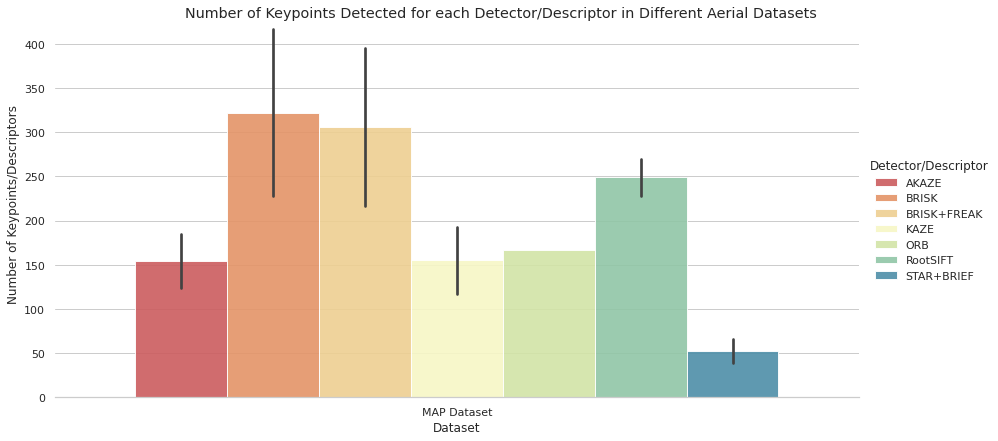

In [126]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_7, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [127]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [128]:
df_numkey_7.to_csv(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [129]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_akaze + num_matches_brisk + num_matches_freak + num_matches_kaze + num_matches_orb + num_matches_rootsift + num_matches_briefstar, 'Detector/Descriptor': ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['KAZE']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1)  + ['STAR+BRIEF']*(len_files-1)  }
df_match_7 = pd.DataFrame(data=d)
df_match_7['Number of Total Matches'] = df_match_7['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

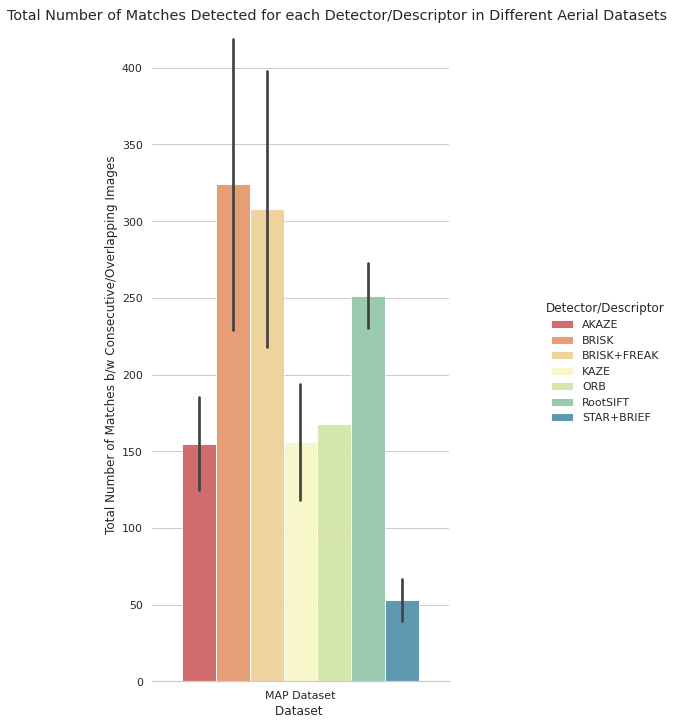

In [130]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [131]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [132]:
df_match_7['Number of Good Matches'] = num_good_matches_akaze + num_good_matches_brisk + num_good_matches_freak + num_good_matches_kaze + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_briefstar
df_match_7['Number of Good Matches'] = df_match_7['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

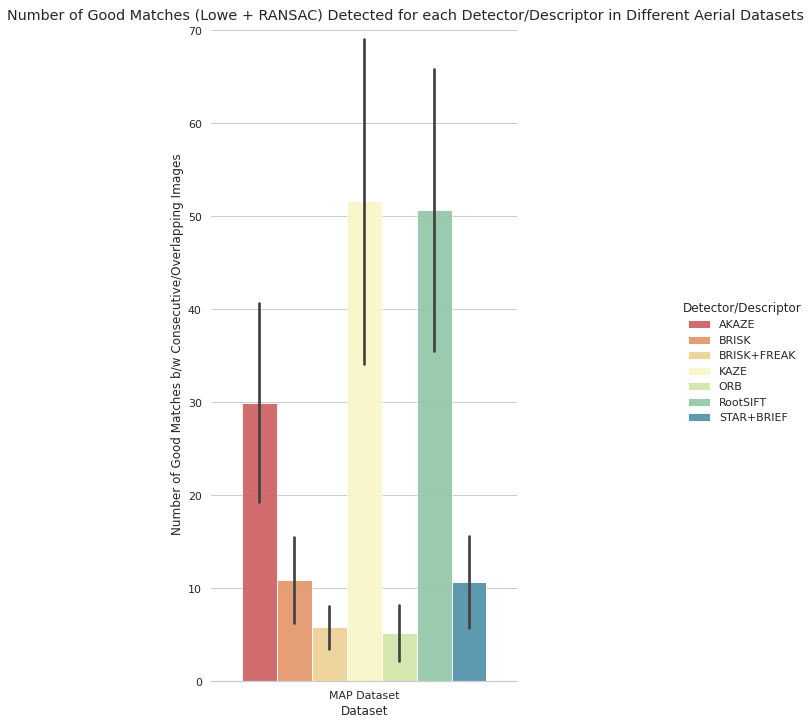

In [133]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [134]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [135]:
df_match_7['Recall Rate of Matches'] = df_match_7['Number of Good Matches']/df_match_7['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

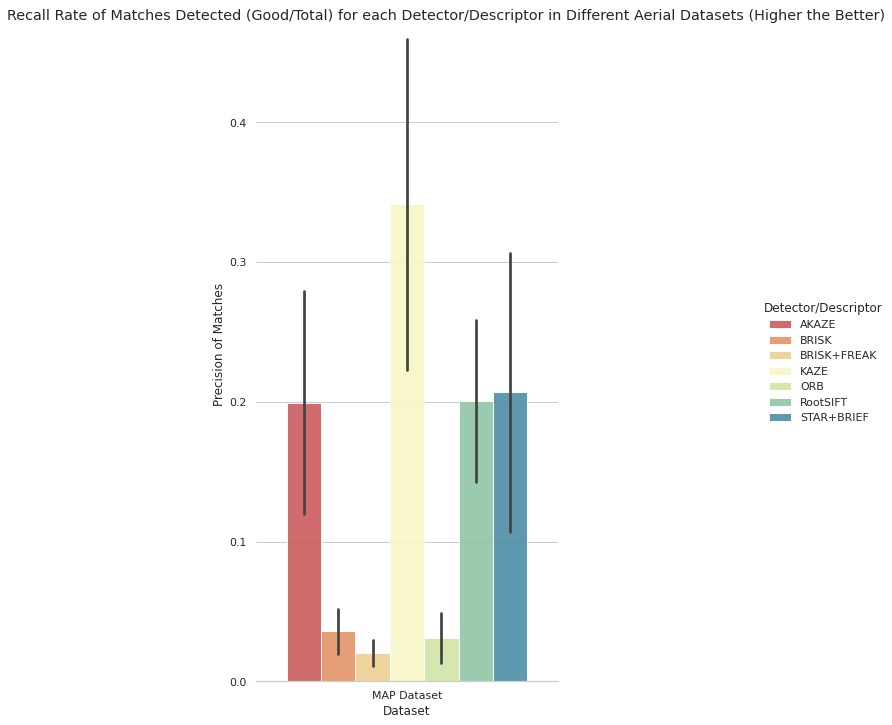

In [136]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [137]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [138]:
df_match_7['1 - Precision Rate of Matches'] = (df_match_7['Number of Total Matches'] - df_match_7['Number of Good Matches'])/df_match_7['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

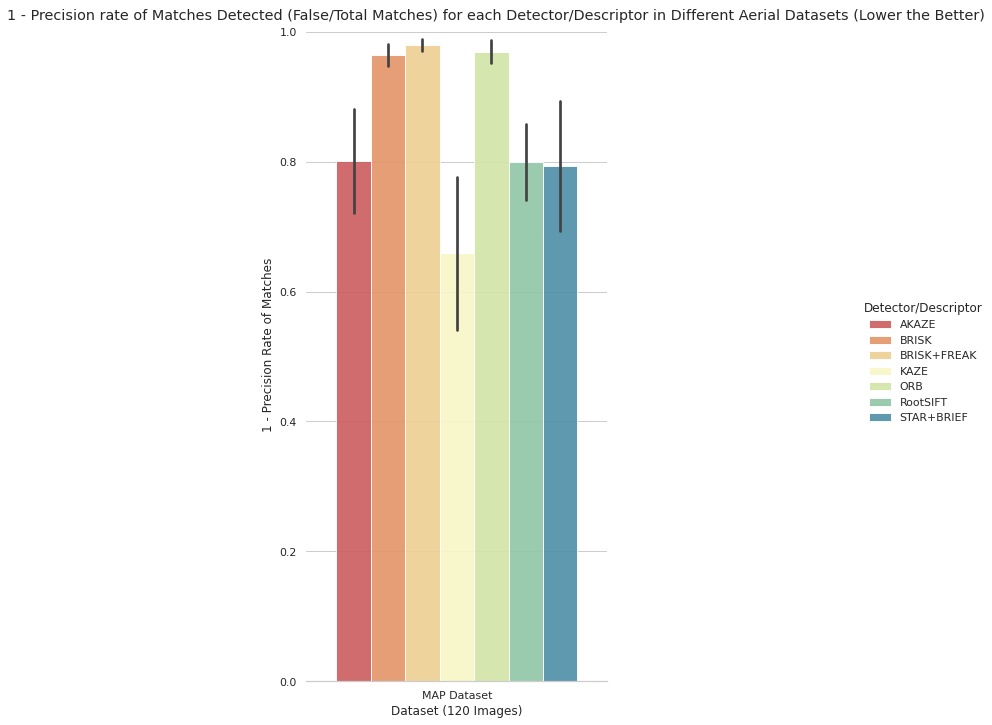

In [139]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [140]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [141]:
df_match_7['F-Score'] = (2* (1 - df_match_7['1 - Precision Rate of Matches']) * df_match_7['Recall Rate of Matches'])/((1 - df_match_7['1 - Precision Rate of Matches']) + df_match_7['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

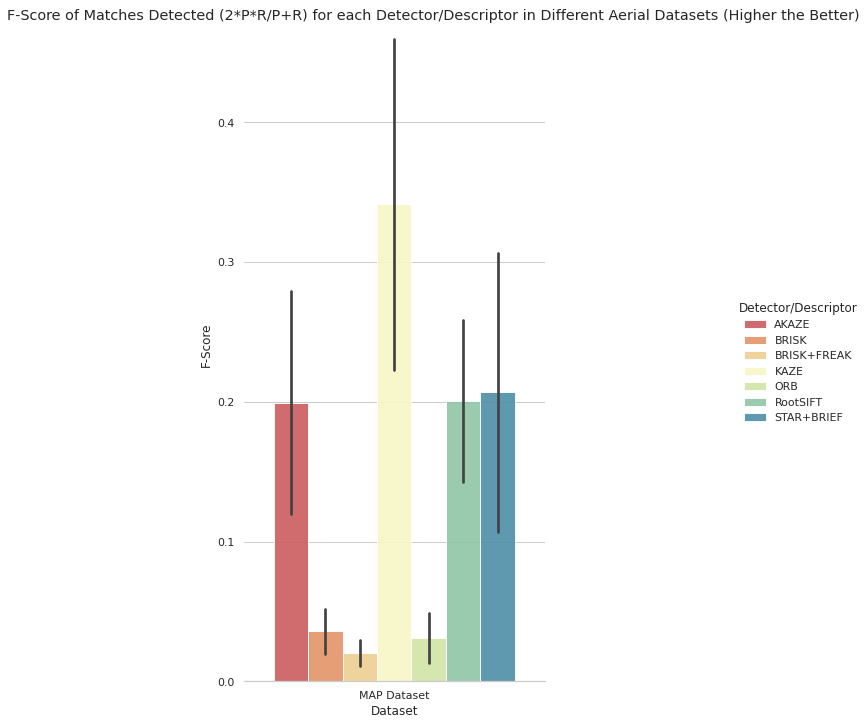

In [142]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_7, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [143]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [144]:
df_match_7.to_csv('drive/MyDrive/All_metrics_7.csv')

Time for each Detector+Descriptor

In [145]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[2]] + [time_all[6]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AKAZE'] + ['BRISK']*(1) + ['BRISK+FREAK']*(1) + ['KAZE']*(1) +  ['ORB']*(1) +['RootSIFT']*(1) + ['STAR+BRIEF']*(1) }
df_time_7 = pd.DataFrame(data=d)

In [146]:
print(df_time_7)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  175.808685               AKAZE
1  MAP Dataset  165.083154               BRISK
2  MAP Dataset  132.863590         BRISK+FREAK
3  MAP Dataset  878.354397                KAZE
4  MAP Dataset  355.820332                 ORB
5  MAP Dataset   35.532850            RootSIFT
6  MAP Dataset   24.083303          STAR+BRIEF


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

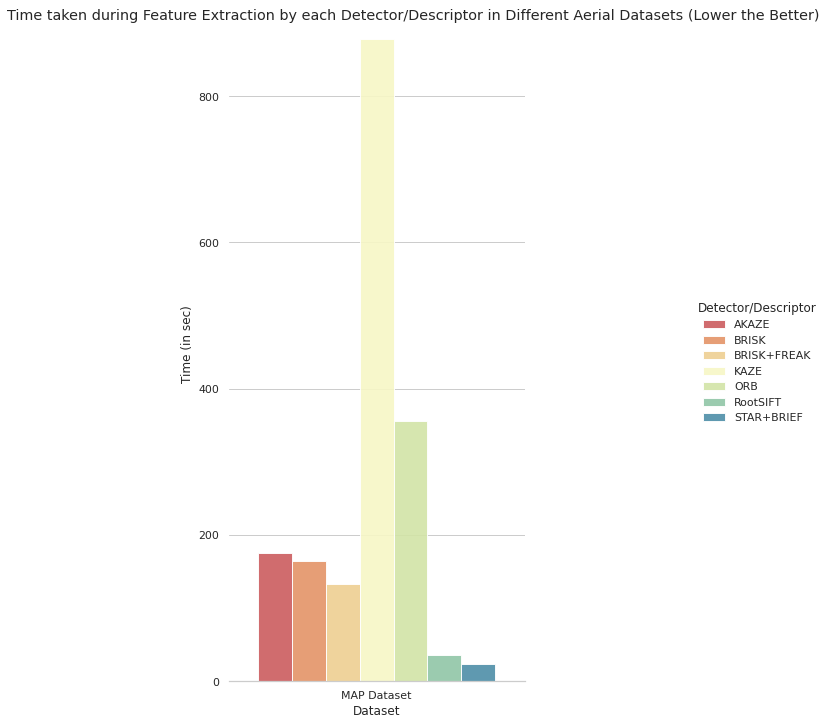

In [147]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_7, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [148]:
g.savefig('drive/MyDrive/Time_7.png')

In [149]:
df_time_7.to_csv('drive/MyDrive/Time_7.csv')

Stitching with CPU